# Energy Consumption by household in the UK


In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib
import os
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

import math

from sklearn import decomposition

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

import warnings
warnings.filterwarnings('ignore')
import joblib

<ipython-input-1-5bcd47c041a9>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## PreProcessing

In [16]:
# Importing the final dataset #
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario1.csv',
                             keep_default_na=False)

In [17]:
weather_energy.columns

Index(['time', 'energy(kWh/hh)', 'visibility', 'windBearing', 'temperature',
       'dewPoint', 'pressure', 'apparentTemperature', 'windSpeed', 'humidity'],
      dtype='object')

In [18]:
weather_energy.drop('time', axis=1, inplace=True)

Using lags of upto 12 hours we are going to convert this into a supervised problem. 

In [19]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'energy(kWh/hh)']
dataset = dataframe.values
dataset = dataset.astype('float32')

Next, data is reframed to work for a supervised prediction model

In [20]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [21]:
reframed = series_to_supervised(dataset, 24,1)
reframed.head(3)

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,0.127,0.178,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,...,1.106,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072
25,0.178,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,0.283,...,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091
26,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,0.283,0.231,...,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054


In [22]:
# Select required columns and merge with supervised data
df = weather_energy
df = df[12:]
reframed = pd.concat([df, reframed], axis=1).dropna()
reframed

,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,var1(t-24),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,0.072,13.70,232,11.59,7.18,1020.11,11.59,7.56,0.74,0.127,...,1.106,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072
25,0.091,14.13,229,11.98,7.98,1019.28,11.98,7.72,0.77,0.178,...,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091
26,0.054,14.13,229,11.98,7.98,1019.28,11.98,7.72,0.77,0.352,...,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054
27,0.068,13.60,233,12.08,8.28,1018.36,12.08,7.89,0.78,0.215,...,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054,0.068
28,0.084,13.60,233,12.08,8.28,1018.36,12.08,7.89,0.78,0.135,...,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054,0.068,0.084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39547,0.080,4.78,40,4.18,2.69,1000.13,1.26,3.37,0.90,0.146,...,0.341,0.085,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080
39548,0.067,13.81,225,5.63,2.26,998.42,2.71,3.85,0.79,0.445,...,0.085,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067
39549,0.406,12.15,231,6.72,-1.73,988.90,2.94,6.33,0.55,0.055,...,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067,0.406
39550,0.145,12.39,228,8.59,2.30,983.69,3.92,12.02,0.65,0.276,...,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067,0.406,0.145


In [23]:
reframed = reframed.reindex(reframed.columns, axis=1)
reframed = reframed.values
reframed

array([[7.20000000e-02, 1.37000000e+01, 2.32000000e+02, ...,
        7.22999990e-01, 1.70000002e-01, 7.19999969e-02],
       [9.10000000e-02, 1.41300000e+01, 2.29000000e+02, ...,
        1.70000002e-01, 7.19999969e-02, 9.09999982e-02],
       [5.40000000e-02, 1.41300000e+01, 2.29000000e+02, ...,
        7.19999969e-02, 9.09999982e-02, 5.40000014e-02],
       ...,
       [4.06000000e-01, 1.21500000e+01, 2.31000000e+02, ...,
        7.99999982e-02, 6.70000017e-02, 4.05999988e-01],
       [1.45000000e-01, 1.23900000e+01, 2.28000000e+02, ...,
        6.70000017e-02, 4.05999988e-01, 1.44999996e-01],
       [3.48000000e-01, 1.26800000e+01, 2.47000000e+02, ...,
        4.05999988e-01, 1.44999996e-01, 3.47999990e-01]])

**Normalization**

The last 48 readings, corresponding to 1h, are set as the testing set, and the rest is training set

In [24]:
# split into train and test sets
train = reframed[:(len(reframed)-2), :]
test = reframed[(len(reframed)-2):len(reframed), :]

To avoid certain features on higher scales overly-affecting the model, all continous data needs to be scaled.   

In [25]:
# PreProcessing of dataset to feed to models
scaler = MinMaxScaler(feature_range=(0, 1))

Data is split between target variable and independent variables

In [26]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

The scaler must be fit on just the training set, to prevent overfitting (which means the prediction model following the trends of the training set too closely and therefore including noise in its prediction, which reduces its performance on the test set).

In [27]:
# Fit on training data and normalize it
train_X = scaler.fit_transform(train_X)

In [28]:
# Tranform the test set
test_X = scaler.transform(test_X)

In [29]:
train_X.shape

(39526, 33)

## Household energy models

Models are created separately. Lists are held with their performances, so a dataframe can be plotted at the end to compare them.

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
R2_scores = []
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []
train_times = []
models_predictions = ['MLR', 'SVM', 'RF', 'FFNNs', 'LSTM', 'RNN', 'Dense+LSTM']

### multiple linear regression (MLR)

The model is fit on the training set.

In [40]:
from sklearn import linear_model
import time
model = linear_model.LinearRegression()
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)
model.coef_

Training time: 0.036 s


array([ 4.89500000e+00, -3.01516729e-10,  4.86594865e-11, -1.40323508e-09,
        2.57117853e-09, -4.63600289e-10, -1.05094493e-09, -8.39955515e-11,
       -1.71114977e-09, -3.60745238e-11, -1.62394058e-09,  7.35073243e-11,
        1.82487768e-09, -1.23152621e-09, -2.04154435e-09,  1.10263396e-09,
        2.48410158e-09,  5.31647089e-10, -1.70212541e-09, -2.44936019e-10,
       -7.41605484e-10, -3.19769725e-10, -4.73652115e-10,  1.72387184e-09,
        1.71259587e-09,  1.39037694e-09,  1.32540411e-10, -7.14520949e-10,
       -1.48798473e-10, -1.73882270e-09,  3.94240293e-09,  2.44055315e-09,
        2.22122898e-09])

A prediction is made on the test set.

In [41]:
# make a prediction
yhat = model.predict(test_X)

In [42]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Then, the prediction is compared to the true target feature values, and the model's performance is calculated. 

In [43]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15}')
print(f'Mse:  {mse:.15}')
print(f'Rmse: {rmse:.15}')
print(f'Mae:  {mae:.15}')
print(f'Mape:  {mape:.15}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999999999999995
Mse:  5.55557329905149e-17
Rmse: 7.45357182768872e-09
Mae:  6.78997955083638e-09
Mape:  2.69853105204834e-06
Training time: 0.036 s


In [44]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

In [45]:
import matplotlib
import seaborn as sns

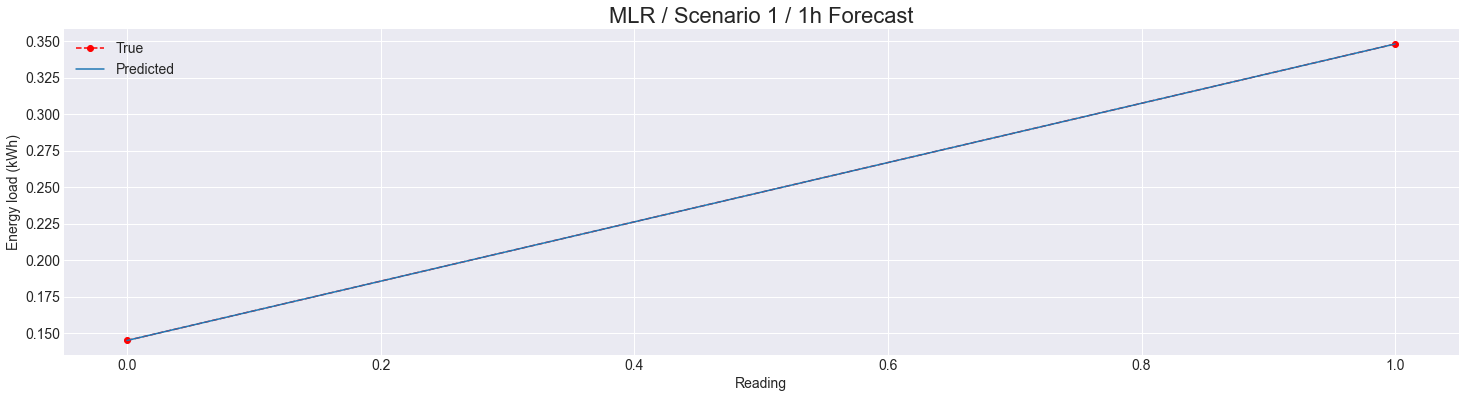

In [46]:
matplotlib.rcParams.update({'font.size': 14})
predicted_mreg = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_mreg['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_mreg['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('MLR / Scenario 1 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario5/S5_1h_MLR.jpeg', dpi = 500)
plt.show()


The model is predicting almost perfectly.

In [47]:
from joblib import dump, load
dump(model, 'C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/MLR_Scenario1.joblib')

['C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/MLR_Scenario1.joblib']

### support vector regressor (SVR)

In [48]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR

In [49]:
model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

Training time: 0.145 s


**Prediction**

In [50]:
# make a prediction
yhat = model.predict(test_X)

In [51]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15}')
print(f'Mse:  {mse:.15}')
print(f'Rmse: {rmse:.15}')
print(f'Mae:  {mae:.15}')
print(f'Mape:  {mape:.15}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999748772672821
Mse:  2.52349907499893e-06
Rmse: 0.00158855250936157
Mae:  0.00127682687387976
Mape:  0.802325412902625
Training time: 0.145 s


In [52]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

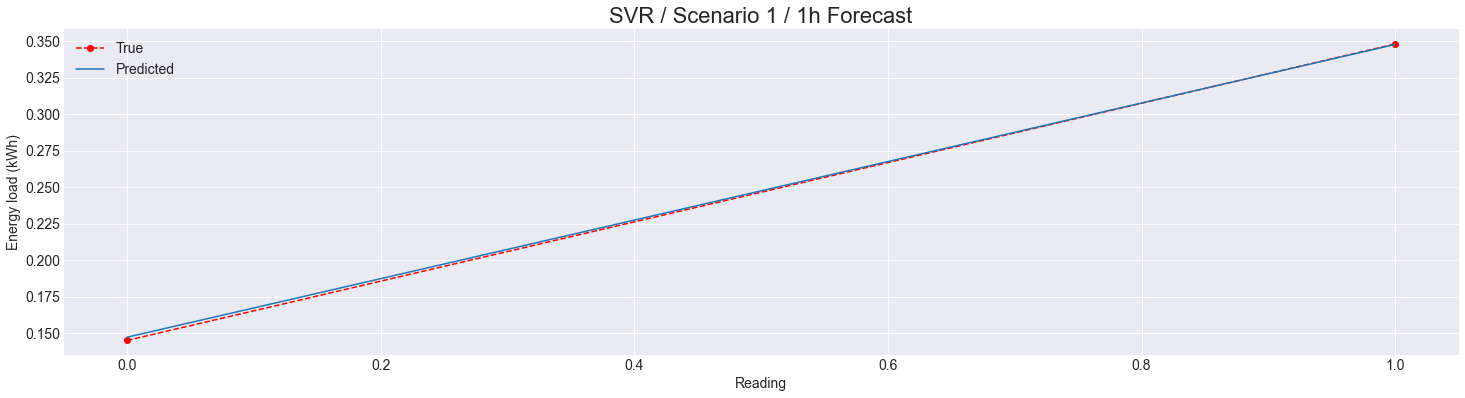

In [53]:
matplotlib.rcParams.update({'font.size': 14})
predicted_svm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_svm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_svm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('SVR / Scenario 1 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario5/S5_1h_SVR.jpeg', dpi = 500)
plt.show()

In [54]:
from joblib import dump, load
dump(model, 'C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/SVR_Scenario1.joblib')

['C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/SVR_Scenario1.joblib']

### random forest (RF)

In [55]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [56]:
model = RandomForestRegressor(bootstrap= True,
                              max_depth= 110,
                              max_features= 0.33,
                              min_samples_leaf= 3,
                              min_samples_split= 10,
                              n_estimators= 100, 
                              criterion='mse')
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

Training time: 23.534 s


**Prediction**

In [57]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.reshape(yhat.shape[0],1)

**Prediction**

In [58]:
# make a prediction
yhat = model.predict(test_X)

In [59]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15}')
print(f'Mse:  {mse:.15}')
print(f'Rmse: {rmse:.15}')
print(f'Mae:  {mae:.15}')
print(f'Mape:  {mape:.15}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.968502795654782
Mse:  0.000244597439414543
Rmse: 0.0156396112296484
Mae:  0.0133768599998226
Mape:  7.22057662627899
Training time: 23.534 s


In [60]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

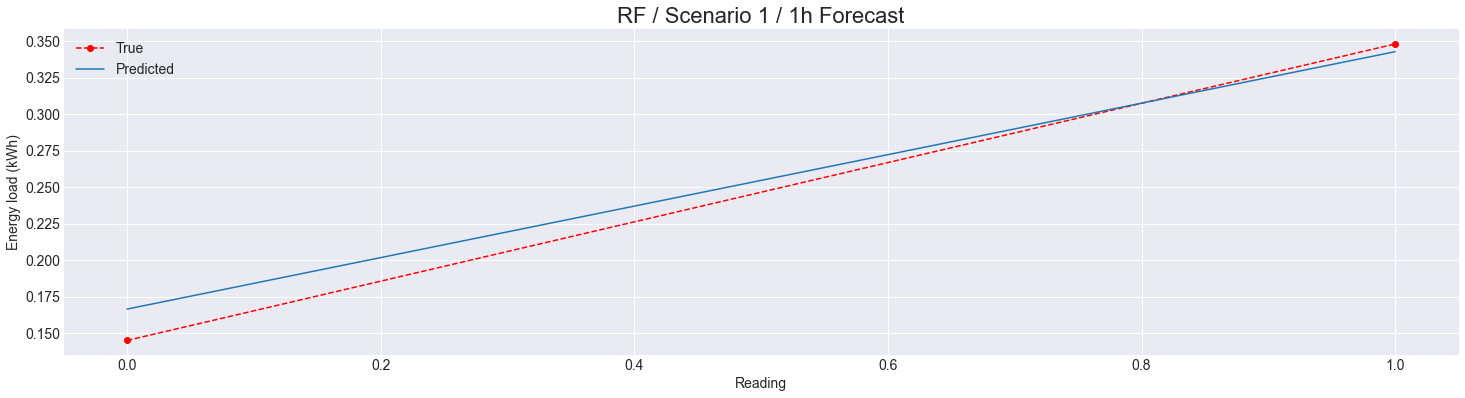

In [61]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rf = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rf['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rf['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RF / Scenario 1 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario5/S5_1h_RF.jpeg', dpi = 500)
plt.show()

The model is predicting very well, picking up on very fine energy consumption trends

### feedforward neural networks (FFNNs)

Data must be reshaped for the neural networks models to work

In [62]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(39526, 1, 33) (39526,) (2, 1, 33) (2,)


In [63]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers import GRU
from keras.layers.convolutional import MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.layers import TimeDistributed
import keras
from keras import layers

In [64]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [65]:
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [66]:
from keras.optimizers import RMSprop

Epoch 1/10
7906/7906 - 6s - loss: 0.0054
Epoch 2/10
7906/7906 - 6s - loss: 5.4085e-04
Epoch 3/10
7906/7906 - 5s - loss: 3.0483e-04
Epoch 4/10
7906/7906 - 5s - loss: 2.0950e-04
Epoch 5/10
7906/7906 - 5s - loss: 1.6634e-04
Epoch 6/10
7906/7906 - 5s - loss: 1.4089e-04
Epoch 7/10
7906/7906 - 5s - loss: 1.1978e-04
Epoch 8/10
7906/7906 - 6s - loss: 1.0378e-04
Epoch 9/10
7906/7906 - 6s - loss: 9.5978e-05
Epoch 10/10
7906/7906 - 5s - loss: 8.8885e-05


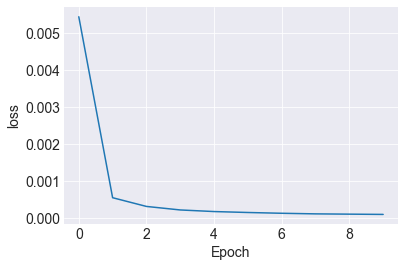

Training time: 55.101 s


In [67]:
model = Sequential()

# Add fully connected layer with a ReLU activation function
model.add(Dense(units=64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(units=64, activation='relu'))

# Add fully connected layer with no activation function
model.add(Dense(units=1))

optimizer = keras.optimizers.RMSprop(lr=0.001, momentum= 0.9)

model.compile(loss='mean_squared_error', # Mean squared error
            optimizer ='RMSprop' # Optimization algorithm
            )

start_time = time.time()
history = model.fit(train_X, train_y, epochs=10, batch_size=5, verbose=2, shuffle=False) 
end_time = time.time()
train_time = end_time - start_time
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [68]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [69]:
yhat

array([0.15234233, 0.34929395], dtype=float32)

In [70]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15}')
print(f'Mse:  {mse:.15}')
print(f'Rmse: {rmse:.15}')
print(f'Mae:  {mae:.15}')
print(f'Mape:  {mape:.15}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.997134088643123
Mse:  2.77921304405737e-05
Rmse: 0.00527182420425546
Mae:  0.00431814789772034
Mape:  2.59504024751703
Training time: 55.101 s


In [71]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

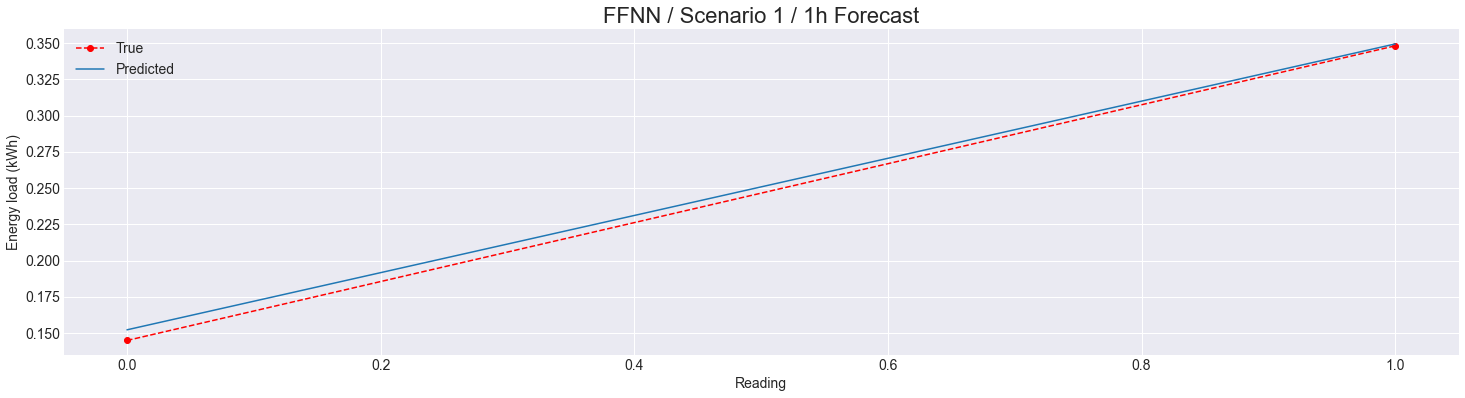

In [72]:
matplotlib.rcParams.update({'font.size': 14})
predicted_fnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_fnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_fnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('FFNN / Scenario 1 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario5/S5_1h_FFNN.jpeg', dpi = 500)
plt.show()

Good predictions, although a bit worse compared to the RF.

### LSTM

In [73]:
from keras.wrappers.scikit_learn import KerasRegressor
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [74]:
from keras.optimizers import Adam

Epoch 1/30
1647/1647 - 2s - loss: 0.0325
Epoch 2/30
1647/1647 - 2s - loss: 6.2668e-04
Epoch 3/30
1647/1647 - 2s - loss: 4.7891e-04
Epoch 4/30
1647/1647 - 2s - loss: 1.5721e-04
Epoch 5/30
1647/1647 - 2s - loss: 2.4301e-04
Epoch 6/30
1647/1647 - 2s - loss: 2.2566e-04
Epoch 7/30
1647/1647 - 2s - loss: 1.6110e-04
Epoch 8/30
1647/1647 - 2s - loss: 3.1362e-04
Epoch 9/30
1647/1647 - 2s - loss: 8.7833e-05
Epoch 10/30
1647/1647 - 2s - loss: 2.8575e-05
Epoch 11/30
1647/1647 - 3s - loss: 1.1632e-04
Epoch 12/30
1647/1647 - 2s - loss: 6.0055e-05
Epoch 13/30
1647/1647 - 2s - loss: 7.3602e-05
Epoch 14/30
1647/1647 - 2s - loss: 1.1350e-04
Epoch 15/30
1647/1647 - 2s - loss: 2.7155e-05
Epoch 16/30
1647/1647 - 2s - loss: 7.8050e-05
Epoch 17/30
1647/1647 - 2s - loss: 5.1572e-05
Epoch 18/30
1647/1647 - 2s - loss: 1.5516e-04
Epoch 19/30
1647/1647 - 2s - loss: 7.3646e-05
Epoch 20/30
1647/1647 - 2s - loss: 8.8541e-05
Epoch 21/30
1647/1647 - 2s - loss: 2.4303e-04
Epoch 22/30
1647/1647 - 2s - loss: 1.8591e-05
E

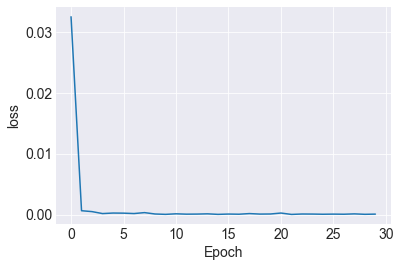

Training time: 65.252 s


In [75]:
# design network
model = Sequential()
model.add(LSTM(128,  activation='softplus', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )



start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [76]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [77]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15}')
print(f'Mse:  {mse:.15}')
print(f'Rmse: {rmse:.15}')
print(f'Mae:  {mae:.15}')
print(f'Mape:  {mape:.15}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999992849441986
Mse:  7.38100269792596e-08
Rmse: 0.000271680008427671
Mae:  0.000253155827522278
Mape:  0.143806445944804
Training time: 65.252 s


In [78]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

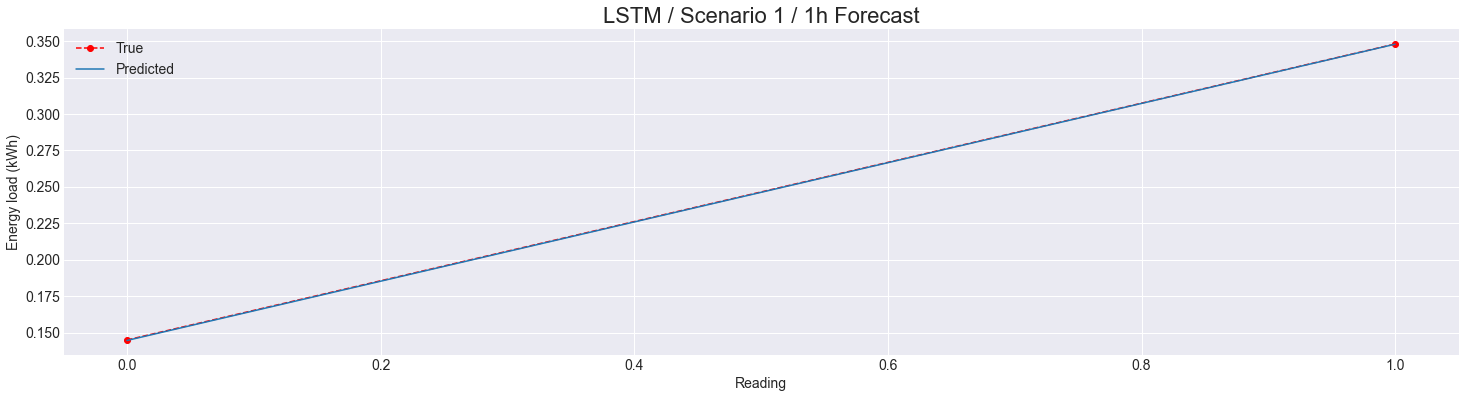

In [79]:
matplotlib.rcParams.update({'font.size': 14})
predicted_lstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_lstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_lstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('LSTM / Scenario 1 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario5/S5_1h_LSTM.jpeg', dpi = 500)
plt.show()

The model is doing well, better than the previous NN, however not as good as MLR and RF.

### RNN

In [80]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Epoch 1/30
1647/1647 - 1s - loss: 0.0145
Epoch 2/30
1647/1647 - 2s - loss: 1.4676e-04
Epoch 3/30
1647/1647 - 2s - loss: 3.4481e-04
Epoch 4/30
1647/1647 - 1s - loss: 2.7777e-04
Epoch 5/30
1647/1647 - 1s - loss: 1.9114e-04
Epoch 6/30
1647/1647 - 2s - loss: 3.0563e-04
Epoch 7/30
1647/1647 - 1s - loss: 3.5289e-05
Epoch 8/30
1647/1647 - 2s - loss: 2.8372e-04
Epoch 9/30
1647/1647 - 1s - loss: 7.2987e-04
Epoch 10/30
1647/1647 - 1s - loss: 2.2966e-05
Epoch 11/30
1647/1647 - 1s - loss: 5.3463e-05
Epoch 12/30
1647/1647 - 1s - loss: 2.4570e-04
Epoch 13/30
1647/1647 - 1s - loss: 7.7957e-05
Epoch 14/30
1647/1647 - 1s - loss: 8.1540e-04
Epoch 15/30
1647/1647 - 1s - loss: 2.1219e-05
Epoch 16/30
1647/1647 - 1s - loss: 9.3758e-05
Epoch 17/30
1647/1647 - 2s - loss: 9.8086e-05
Epoch 18/30
1647/1647 - 1s - loss: 7.7007e-05
Epoch 19/30
1647/1647 - 1s - loss: 3.2624e-04
Epoch 20/30
1647/1647 - 1s - loss: 2.3135e-05
Epoch 21/30
1647/1647 - 1s - loss: 4.0150e-04
Epoch 22/30
1647/1647 - 1s - loss: 2.2871e-05
E

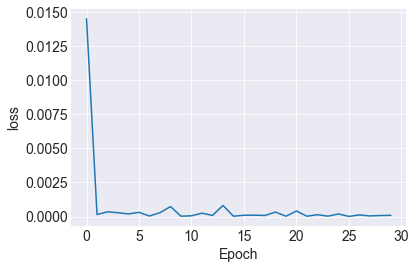

Training time: 44.294 s


In [81]:
# design network
model = Sequential()
model.add(SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )


start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

In [82]:
model.save('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario1.h5')

In [83]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario1.h5")
print("Saved model to disk")
 

Saved model to disk


In [84]:
from keras.models import model_from_json


In [85]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario1.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data


Loaded model from disk


**Prediction**

In [86]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [87]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15}')
print(f'Mse:  {mse:.15}')
print(f'Rmse: {rmse:.15}')
print(f'Mae:  {mae:.15}')
print(f'Mape:  {mape:.15}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999984686245074
Mse:  1.57807538592181e-07
Rmse: 0.000397249969908345
Mae:  0.000397026538848877
Mape:  0.190851467007086
Training time: 44.294 s


In [88]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

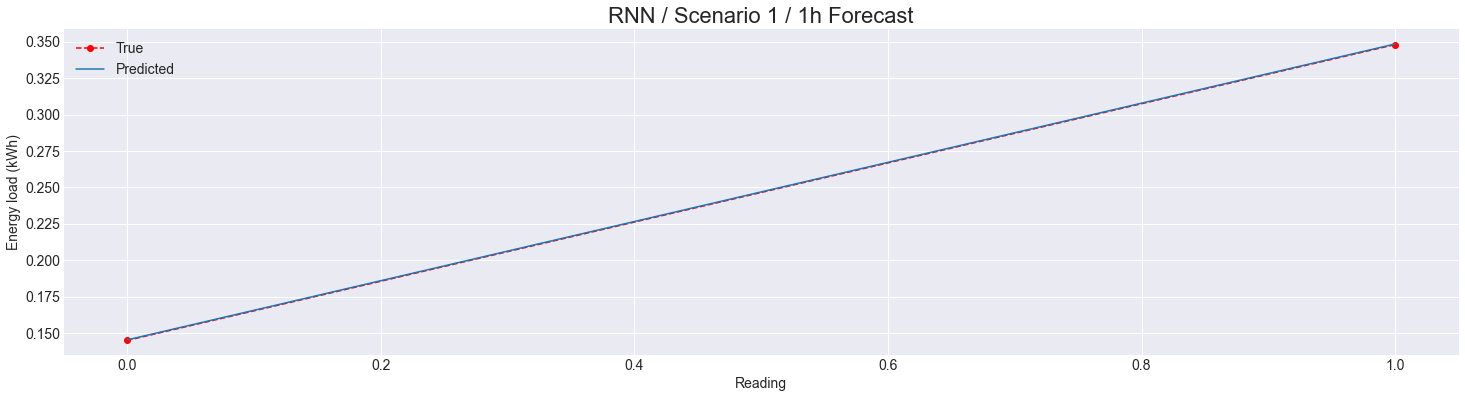

In [89]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN / Scenario 1 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario5/S5_1h_RNN.jpeg', dpi = 500)
plt.show()

The model is doing well however its accuracy is worse than that of CNN-LSTM. However, it's training 4 times faster. 

Because this model achieved the best performance, saving it:

### Dense + LSTM

Epoch 1/30
618/618 - 1s - loss: 0.0716
Epoch 2/30
618/618 - 1s - loss: 0.0099
Epoch 3/30
618/618 - 2s - loss: 6.4874e-04
Epoch 4/30
618/618 - 2s - loss: 5.5543e-04
Epoch 5/30
618/618 - 2s - loss: 4.4368e-04
Epoch 6/30
618/618 - 2s - loss: 4.1831e-04
Epoch 7/30
618/618 - 2s - loss: 3.6832e-04
Epoch 8/30
618/618 - 1s - loss: 3.1521e-04
Epoch 9/30
618/618 - 1s - loss: 2.4767e-04
Epoch 10/30
618/618 - 1s - loss: 2.3456e-04
Epoch 11/30
618/618 - 1s - loss: 2.6269e-04
Epoch 12/30
618/618 - 1s - loss: 1.6778e-04
Epoch 13/30
618/618 - 1s - loss: 2.0951e-04
Epoch 14/30
618/618 - 1s - loss: 3.0647e-04
Epoch 15/30
618/618 - 1s - loss: 1.2933e-04
Epoch 16/30
618/618 - 1s - loss: 1.0757e-04
Epoch 17/30
618/618 - 1s - loss: 1.5017e-04
Epoch 18/30
618/618 - 1s - loss: 1.3630e-04
Epoch 19/30
618/618 - 1s - loss: 1.4167e-04
Epoch 20/30
618/618 - 1s - loss: 1.5934e-04
Epoch 21/30
618/618 - 1s - loss: 8.2867e-05
Epoch 22/30
618/618 - 1s - loss: 1.0893e-04
Epoch 23/30
618/618 - 1s - loss: 9.0055e-05
Epoch

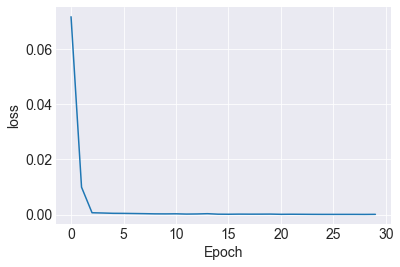

Training time: 45.138 s


In [90]:
# design network
model = Sequential()
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(LSTM(128))
model.add(Dense(1))
optimizer = Adam(lr=0.0001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )

#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc']) #mae

start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=64, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

In [91]:
model.save('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/dense_LSTM_Scenario1_1h.h5')

**Prediction**

In [92]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [93]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15}')
print(f'Mse:  {mse:.15}')
print(f'Rmse: {rmse:.15}')
print(f'Mae:  {mae:.15}')
print(f'Mape:  {mape:.15}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.990067953473271
Mse:  8.62726977666206e-05
Rmse: 0.00928830973679391
Mae:  0.00829969346523285
Mape:  4.55984797954486
Training time: 45.138 s


In [94]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

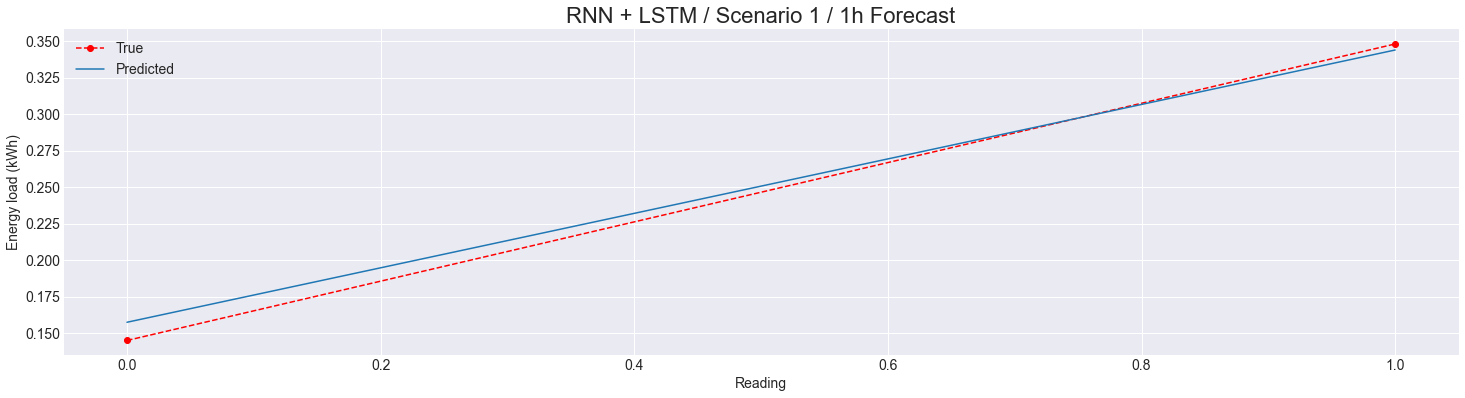

In [95]:
matplotlib.rcParams.update({'font.size': 14})
predicted_denselstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_denselstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_denselstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN + LSTM / Scenario 1 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario5/S5_1h_RNN_LSTM.jpeg', dpi = 500)
plt.show()

This is the best model, the predictions accurately follow the observed energy consumption.


## Best model

In [ ]:
models_performances = pd.DataFrame([R2_scores,MSE_scores,RMSE_scores,MAE_scores,MAPE_scores,train_times],
                                   columns=models_predictions, 
                                   index=['R2_scores', 'MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores', 'Train_Time'])
models_performances

,MLR,SVM,RF,FFNNs,LSTM,RNN,Dense+LSTM
R2_scores,1.000000e+00,0.999749,0.968503,0.991416,0.995200,0.999044,0.980315
MSE_scores,5.555573e-17,0.000003,0.000245,0.000088,0.000050,0.000009,0.000165
RMSE_scores,7.453572e-09,0.001589,0.015640,0.009385,0.007098,0.003070,0.012831
MAE_scores,6.789980e-09,0.001277,0.013377,0.009382,0.007034,0.002226,0.010046
MAPE_scores,2.698531e-06,0.802325,7.220577,4.386076,3.134998,1.469170,5.827482
Train_Time,3.889585e-02,0.117728,19.806956,49.030201,62.660942,46.371375,44.130142


In [ ]:
models_performances.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/BestModel_Scenario1_1h.csv', index=False)

**Plotting all models together.**

In [96]:
prev_day = train_y[-48:] #energy readings from previous day
y_plotting = np.concatenate([prev_day, test_y], axis=0)

In [97]:

# Get all predictions from the models
predicted_energy=[predicted_mreg['predicted'],
                  predicted_svm['predicted'],
                  predicted_rf['predicted'],
                  predicted_fnn['predicted'],
                  predicted_lstm['predicted'],
                  predicted_rnn['predicted'],
                  predicted_denselstm['predicted']]

In [98]:
prev_2days = sorted(pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario1.csv').time)[-96:]

In [99]:
df_for_plotting = pd.DataFrame(y_plotting, index=prev_2days, columns=['Original'])

ValueError: ignored

In [ ]:
# Initialize all columns with null values
df_for_plotting["Train"] = np.nan
# Add a column for each model's predictions
col_names=['MLR', 'SVR', 'RF', 'FFNN', 'LSTM', 'RNN', 'Dense-LSTM']
for col_name in col_names:
  df_for_plotting[col_name+' forecast'] = np.nan

In [ ]:
# Fill in with corresponding values
df_for_plotting["Train"][:-48] = prev_day

for i, model_pred in enumerate(predicted_energy):
  df_for_plotting[col_names[i]+' forecast'][-48:] = model_pred

In [ ]:
# Turn index to datetime
df_for_plotting.index = pd.to_datetime(df_for_plotting.index)

In [ ]:
df_for_plotting.columns

In [ ]:
import datetime
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

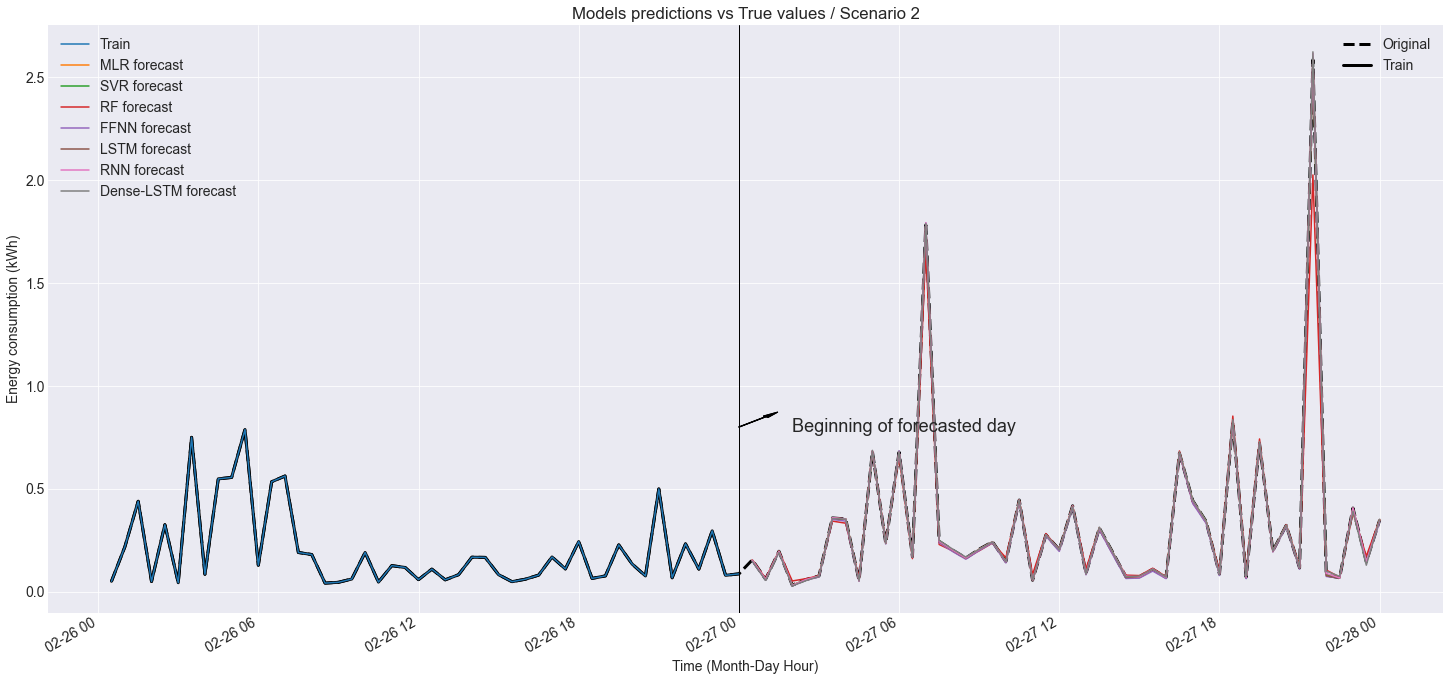

In [ ]:
import matplotlib.dates as md

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)


# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='K', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[1:]:
  df_for_plotting[forecast].plot(label=forecast)

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00:00')
plt.text(label_x_pos, 0.8, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)


# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.8, dx, 0.05, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)


plt.title('Models predictions vs True values / Scenario 5')

plt.legend()
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario5/S5_1h_OriginalPredicted_All.jpeg', dpi = 500)
plt.show()

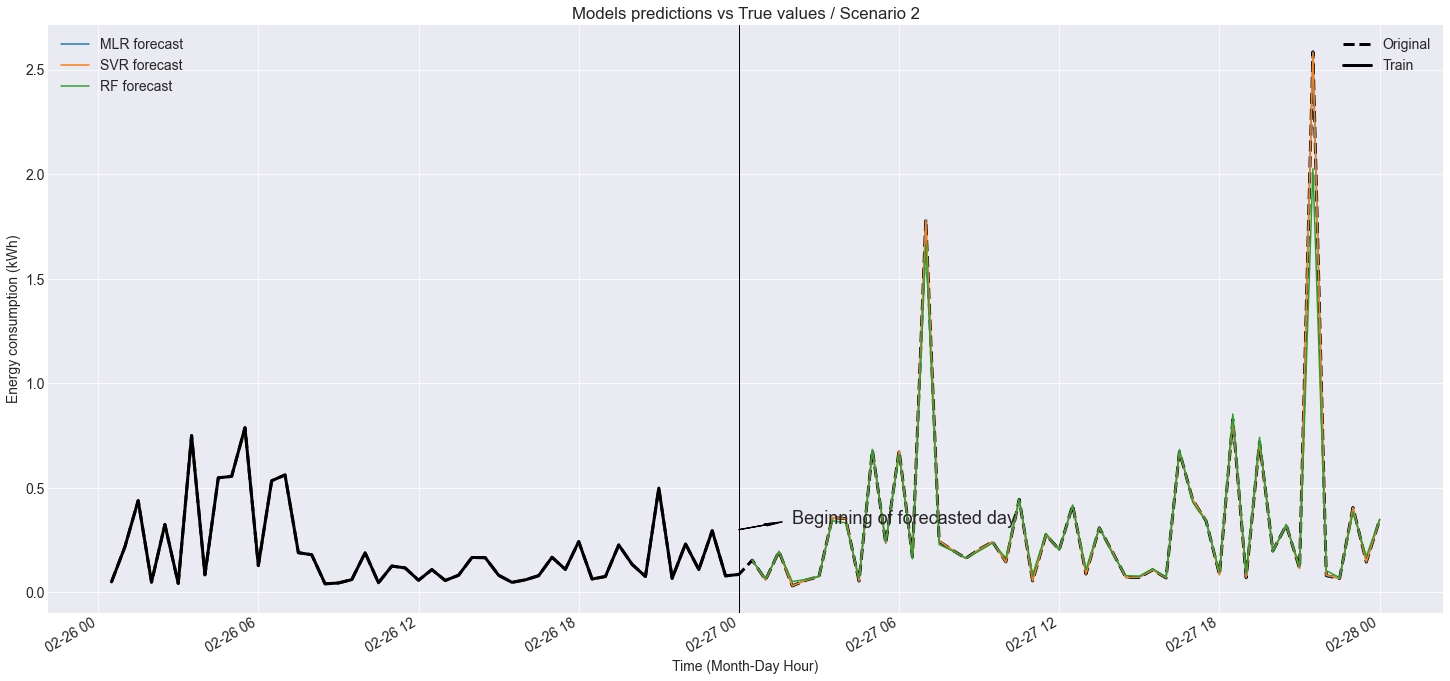

In [ ]:
import matplotlib.dates as md

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='k', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[2:5]:
  df_for_plotting[forecast].plot(label=forecast)

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00')
plt.text(label_x_pos, 0.35, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)

# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.3, dx, 0.023, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)

plt.title('Models predictions vs True values / Scenario 5')

plt.legend()
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario5/S5_1h_RegressionModelsPredicted_All.jpeg', dpi = 500)
plt.show()

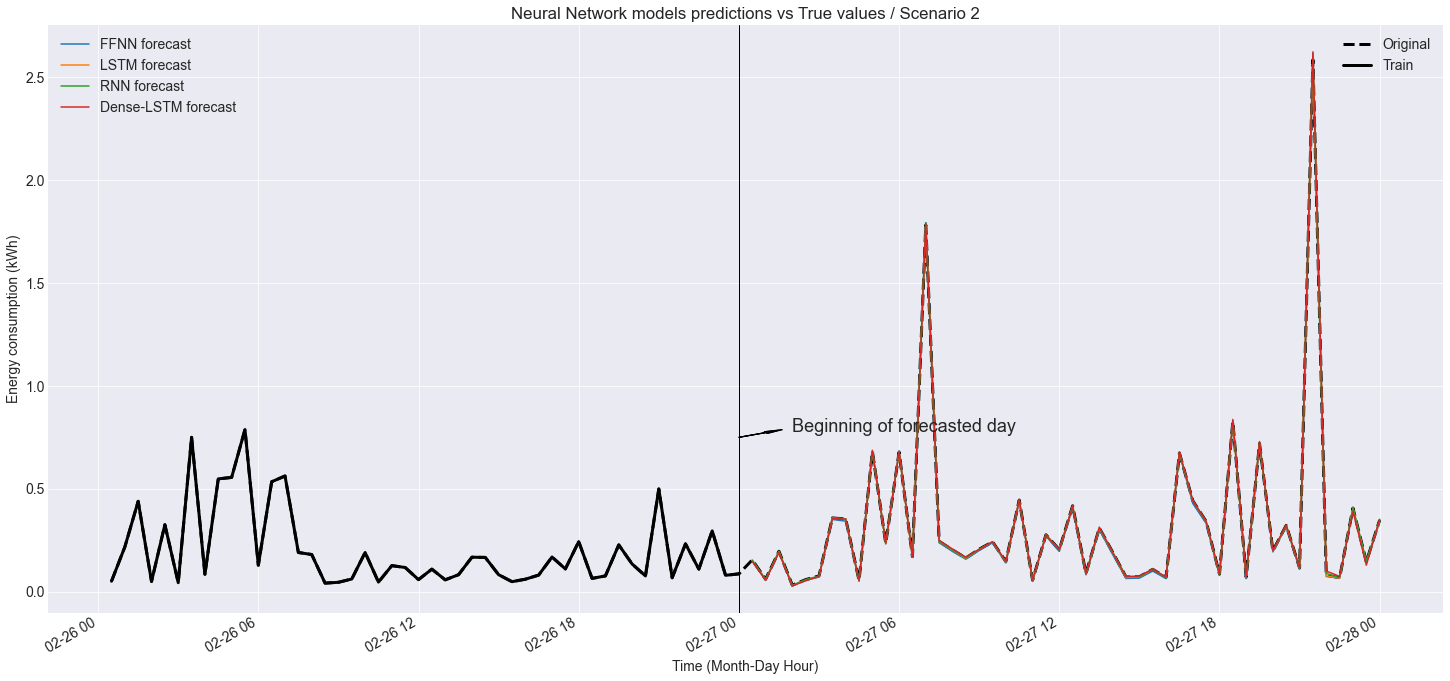

In [ ]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='k', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[5:]:
  df_for_plotting[forecast].plot()

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00')
plt.text(label_x_pos, 0.8, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)

# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.75, dx, 0.023, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)

plt.title('Neural Network models predictions vs True values / Scenario 5')
plt.legend(loc='upper left')
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario5/S5_1h_OriginalPredicted_4_8.jpeg', dpi = 500)
plt.show()

## House level prediction 
-For each half hour, for each of the 33 types.

In [104]:
houses_data = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/all_houses_Scenario4.csv')

In [105]:
houses_data

,LCLid,tstp,energy(kWh/hh)
0,2,2012-10-12 00:30:00,0.000
1,2,2012-10-12 01:00:00,0.000
2,2,2012-10-12 01:30:00,0.000
3,2,2012-10-12 02:00:00,0.000
4,2,2012-10-12 02:30:00,0.000
...,...,...,...
8092712,5124,2014-02-27 22:00:00,0.673
8092713,5124,2014-02-27 22:30:00,0.590
8092714,5124,2014-02-27 23:00:00,0.552
8092715,5124,2014-02-27 23:30:00,0.519


In [106]:
houses_data.rename(columns={'tstp':'time'}, inplace=True)

Merging with the weather_energy data

In [107]:
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario4.csv')

In [108]:
weather_energy.columns[1:]

Index(['year', 'month', 'day', 'hour', 'weekday', 'energy(kWh/hh)',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped', 'weekend'],
      dtype='object')

In [109]:
weather_energy = weather_energy.drop(columns = ['holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped', 'year', 'month', 'day', 'hour', 'weekday', 'weekend'])

In [110]:
updated_houses = houses_data.merge(weather_energy, on='time')

In [111]:
updated_houses

,LCLid,time,energy(kWh/hh)_x,energy(kWh/hh)_y,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
0,2,2012-10-12 00:30:00,0.000,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
1,246,2012-10-12 00:30:00,0.975,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
2,1074,2012-10-12 00:30:00,1.438,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
3,3281,2012-10-12 00:30:00,0.078,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
4,3305,2012-10-12 00:30:00,0.101,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
...,...,...,...,...,...,...,...,...,...,...,...,...
8086036,183,2011-12-03 06:30:00,0.109,0.109,11.73,244,11.00,10.26,1001.07,11.00,6.37,0.95
8086037,183,2011-12-03 07:00:00,0.030,0.030,11.93,253,10.96,9.73,1001.07,10.96,5.48,0.92
8086038,183,2011-12-03 07:30:00,0.082,0.082,11.93,253,10.96,9.73,1001.07,10.96,5.48,0.92
8086039,183,2011-12-03 08:00:00,0.030,0.030,13.71,253,11.01,9.11,1001.55,11.01,6.32,0.88


In [112]:
updated_houses.columns

Index(['LCLid', 'time', 'energy(kWh/hh)_x', 'energy(kWh/hh)_y', 'visibility',
       'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity'],
      dtype='object')

In [113]:
updated_houses.columns = ['LCLid', 'time', 'energy(kWh/hh)', 'energy(kWh/hh)_y', 'visibility',
       'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity']

In [114]:
updated_houses.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S1.csv')

In [115]:
updated_houses = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S1.csv')

In [116]:
updated_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8086041 entries, 0 to 8086040
Data columns (total 13 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Unnamed: 0           int64  
 1   LCLid                int64  
 2   time                 object 
 3   energy(kWh/hh)       float64
 4   energy(kWh/hh)_y     float64
 5   visibility           float64
 6   windBearing          int64  
 7   temperature          float64
 8   dewPoint             float64
 9   pressure             float64
 10  apparentTemperature  float64
 11  windSpeed            float64
 12  humidity             float64
dtypes: float64(9), int64(3), object(1)
memory usage: 802.0+ MB


In [117]:
updated_houses.columns

Index(['Unnamed: 0', 'LCLid', 'time', 'energy(kWh/hh)', 'energy(kWh/hh)_y',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity'],
      dtype='object')

In [118]:
updated_houses.columns = ['Unnamed: 0', 'LCLid', 'time', 'energy(kWh/hh)', 'energy(kWh/hh)_y',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity']

In [119]:
updated_houses


,Unnamed: 0,LCLid,time,energy(kWh/hh),energy(kWh/hh)_y,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
0,0,2,2012-10-12 00:30:00,0.000,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
1,1,246,2012-10-12 00:30:00,0.975,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
2,2,1074,2012-10-12 00:30:00,1.438,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
3,3,3281,2012-10-12 00:30:00,0.078,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
4,4,3305,2012-10-12 00:30:00,0.101,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8086036,8086036,183,2011-12-03 06:30:00,0.109,0.109,11.73,244,11.00,10.26,1001.07,11.00,6.37,0.95
8086037,8086037,183,2011-12-03 07:00:00,0.030,0.030,11.93,253,10.96,9.73,1001.07,10.96,5.48,0.92
8086038,8086038,183,2011-12-03 07:30:00,0.082,0.082,11.93,253,10.96,9.73,1001.07,10.96,5.48,0.92
8086039,8086039,183,2011-12-03 08:00:00,0.030,0.030,13.71,253,11.01,9.11,1001.55,11.01,6.32,0.88


Function to check another household:

In [120]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [121]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [122]:
from keras.models import Sequential, load_model
from joblib import dump, load


In [123]:
updated_houses

,Unnamed: 0,LCLid,time,energy(kWh/hh),energy(kWh/hh)_y,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
0,0,2,2012-10-12 00:30:00,0.000,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
1,1,246,2012-10-12 00:30:00,0.975,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
2,2,1074,2012-10-12 00:30:00,1.438,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
3,3,3281,2012-10-12 00:30:00,0.078,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
4,4,3305,2012-10-12 00:30:00,0.101,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8086036,8086036,183,2011-12-03 06:30:00,0.109,0.109,11.73,244,11.00,10.26,1001.07,11.00,6.37,0.95
8086037,8086037,183,2011-12-03 07:00:00,0.030,0.030,11.93,253,10.96,9.73,1001.07,10.96,5.48,0.92
8086038,8086038,183,2011-12-03 07:30:00,0.082,0.082,11.93,253,10.96,9.73,1001.07,10.96,5.48,0.92
8086039,8086039,183,2011-12-03 08:00:00,0.030,0.030,13.71,253,11.01,9.11,1001.55,11.01,6.32,0.88


In [124]:
updated_houses[updated_houses.LCLid==2]

,Unnamed: 0,LCLid,time,energy(kWh/hh),energy(kWh/hh)_y,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
0,0,2,2012-10-12 00:30:00,0.000,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91
258,258,2,2012-10-12 01:00:00,0.000,0.094,13.50,250,13.09,11.37,1000.10,13.09,6.77,0.89
516,516,2,2012-10-12 01:30:00,0.000,0.125,13.50,250,13.09,11.37,1000.10,13.09,6.77,0.89
774,774,2,2012-10-12 02:00:00,0.000,0.081,13.50,252,12.54,10.27,1000.51,12.54,6.46,0.86
1032,1032,2,2012-10-12 02:30:00,0.000,0.132,13.50,252,12.54,10.27,1000.51,12.54,6.46,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499697,6499697,2,2014-02-27 22:00:00,0.416,0.171,14.00,216,4.10,1.64,1005.67,1.41,3.02,0.84
6499954,6499954,2,2014-02-27 22:30:00,1.350,0.504,14.00,216,4.10,1.64,1005.67,1.41,3.02,0.84
6500211,6500211,2,2014-02-27 23:00:00,1.247,0.176,14.03,200,3.93,1.61,1004.62,1.42,2.75,0.85
6500468,6500468,2,2014-02-27 23:30:00,1.218,0.136,14.03,200,3.93,1.61,1004.62,1.42,2.75,0.85


In [125]:
weather_energy

,time,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
0,2011-11-26 11:30:00,0.127,13.07,238,11.92,7.58,1026.96,11.92,7.21,0.75
1,2011-11-26 12:00:00,0.178,12.83,239,12.48,7.31,1026.25,12.48,7.48,0.71
2,2011-11-26 12:30:00,0.352,12.83,239,12.48,7.31,1026.25,12.48,7.48,0.71
3,2011-11-26 13:00:00,0.215,13.07,243,12.61,7.57,1025.28,12.61,8.15,0.71
4,2011-11-26 13:30:00,0.135,13.07,243,12.61,7.57,1025.28,12.61,8.15,0.71
...,...,...,...,...,...,...,...,...,...,...
39547,2014-01-30 02:00:00,0.080,4.78,40,4.18,2.69,1000.13,1.26,3.37,0.90
39548,2014-02-04 05:30:00,0.067,13.81,225,5.63,2.26,998.42,2.71,3.85,0.79
39549,2014-02-09 17:30:00,0.406,12.15,231,6.72,-1.73,988.90,2.94,6.33,0.55
39550,2014-02-15 07:30:00,0.145,12.39,228,8.59,2.30,983.69,3.92,12.02,0.65


In [126]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                      'HH_2',
                      'HH_3',
                      'HH_4',
                      'HH_5',
                      'HH_6',
                      'HH_7',
                      'HH_8',
                      'HH_9',
                      'HH_10',
                      'HH_11',
                      'HH_12',
                      'HH_13',
                      'HH_14',
                      'HH_15',
                      'HH_16',
                      'HH_17',
                      'HH_18',
                      'HH_19',
                      'HH_20',
                      'HH_21',
                      'HH_22',
                      'HH_23',
                      'HH_24',
                      'HH_25',
                      'HH_26',
                      'HH_27',
                      'HH_28', 
                      'HH_29']

In [127]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-2), :]
  test = reframed[(len(reframed)-2):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  
  # Tranform the test set
  #train_X = scaler.fit_transform(train_X)
  #test_X = scaler.transform(test_X)

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  model = Sequential()
  model.add(SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))

  optimizer = Adam(lr=0.001)

  model.compile(loss='mean_squared_error', # Mean squared error
              optimizer = optimizer # Optimization algorithm
              )


  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15}')
  print(f'Rmse: {rmse_HH:.15}')
  print(f'Mae:  {mae_HH:.15}')
  print(f'Mape:  {mape_HH:.15}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /RNN (Scenario 5)')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario5/2_singleHouseholdLevel/best_NN_model/S5_1h_RNN_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


In [128]:
from keras.optimizers import Adam

Mse:  19351.8623299514
Rmse: 139.110971278154
Mae:  139.110957827419
Mape:  100.089577114212


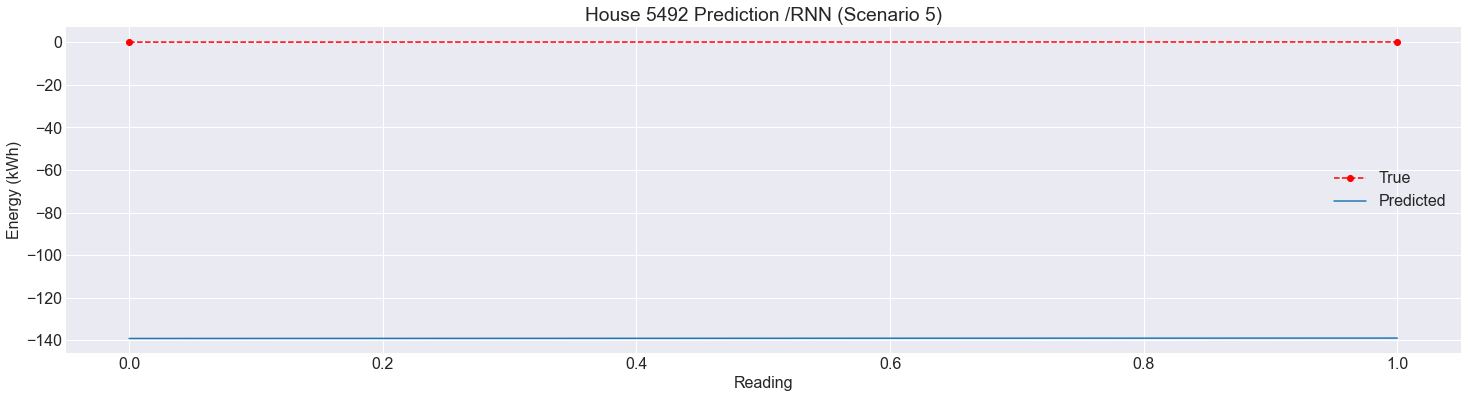

Mse:  18343.8139048749
Rmse: 135.439336622987
Mae:  135.437117312104
Mape:  99.8856832188908


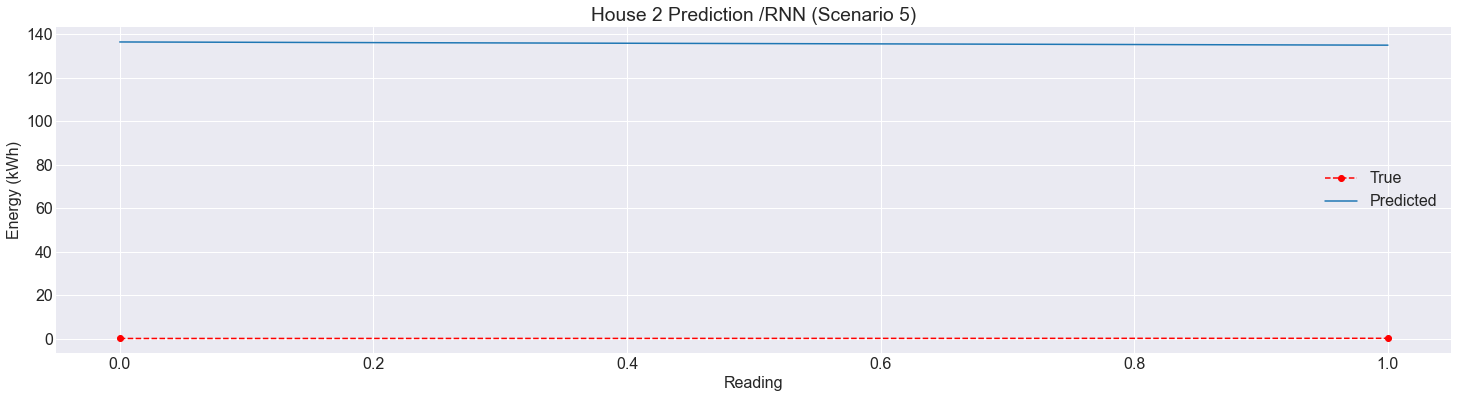

Mse:  95.0537516235465
Rmse: 9.7495513549879
Mae:  9.74893073737621
Mape:  96.7401905803189


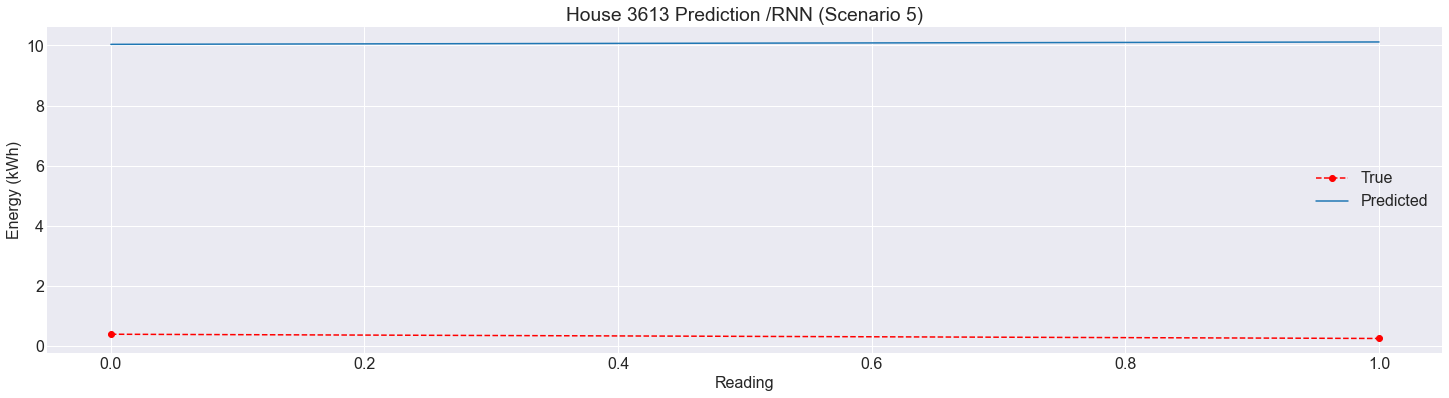

Mse:  231.780283090976
Rmse: 15.2243319423539
Mae:  15.2239231467247
Mape:  98.9889054276729


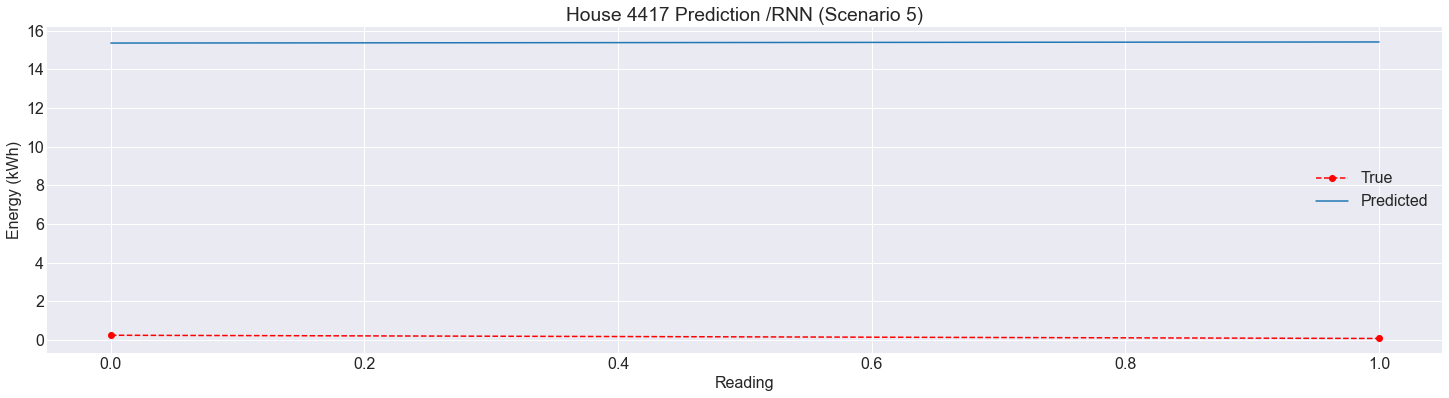

Mse:  639.743425347544
Rmse: 25.293149771184
Mae:  25.2931373286992
Mape:  100.170296147662


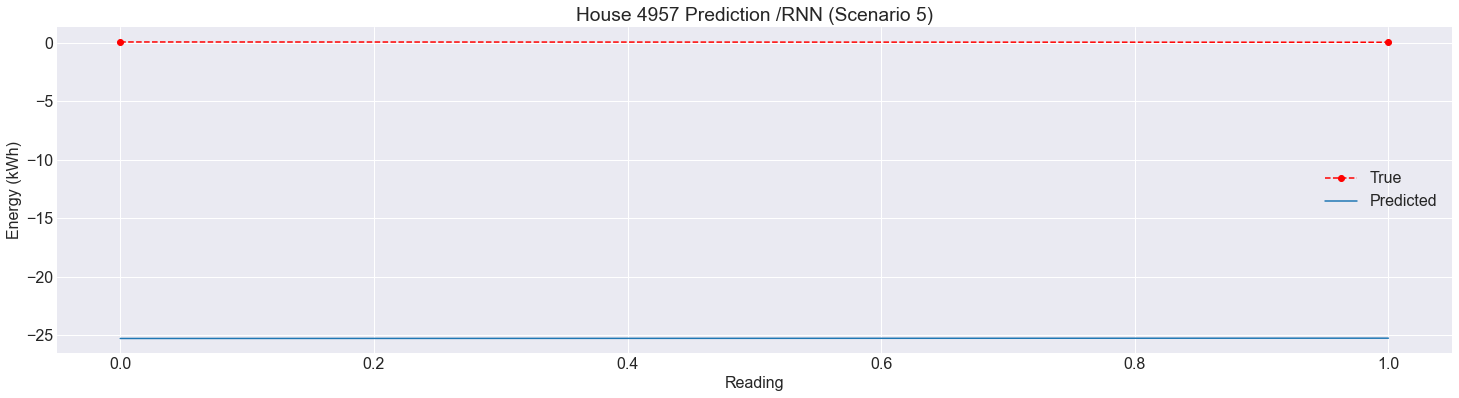

Mse:  37639.7610626032
Rmse: 194.009693218156
Mae:  194.009692501277
Mape:  100.053118334482


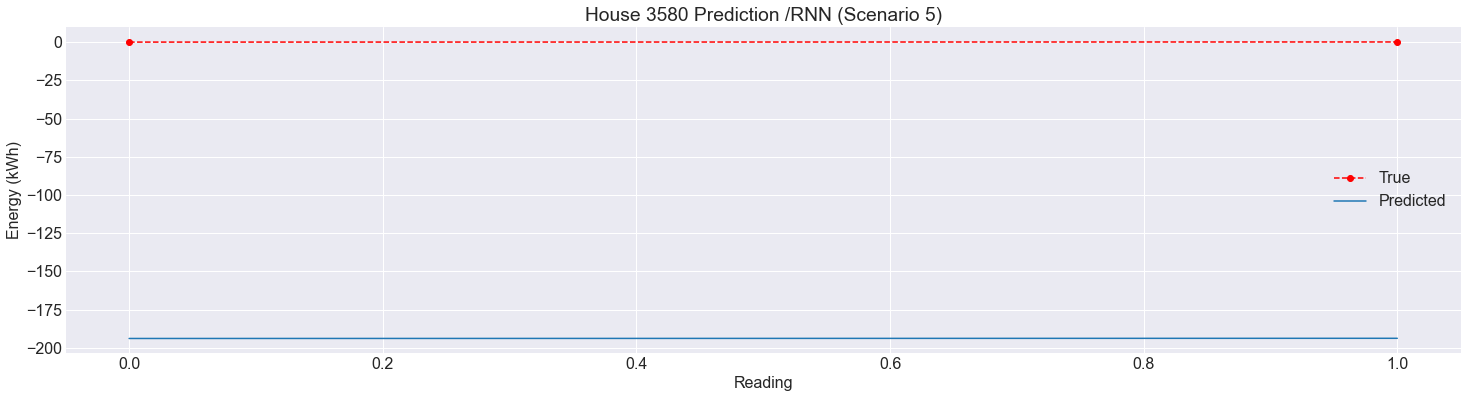

Mse:  16817.2754670235
Rmse: 129.681438405901
Mae:  129.681414123625
Mape:  100.083736704601


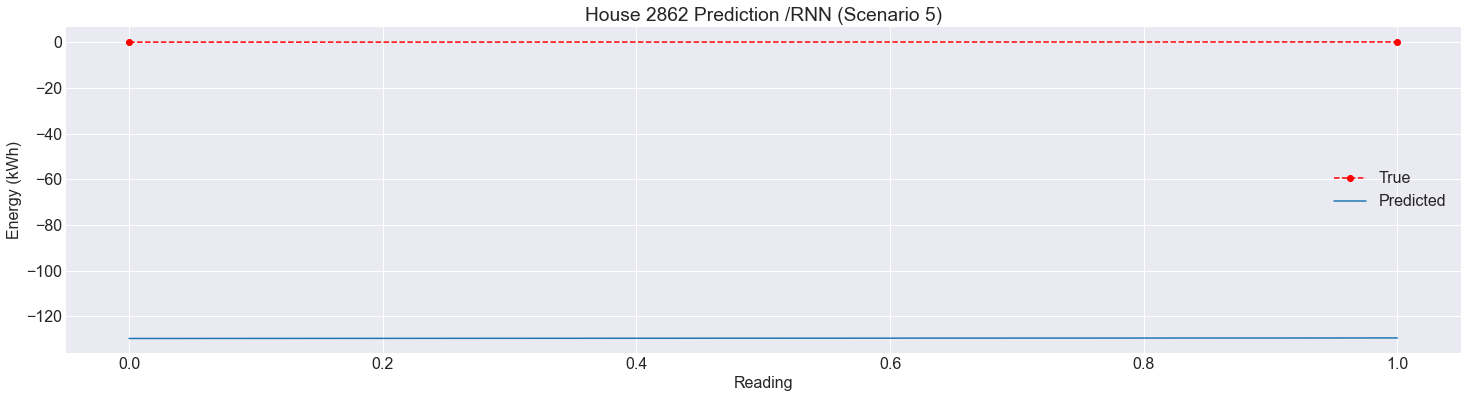

Mse:  19833.0453977288
Rmse: 140.829845550326
Mae:  140.829845398664
Mape:  99.9506740058435


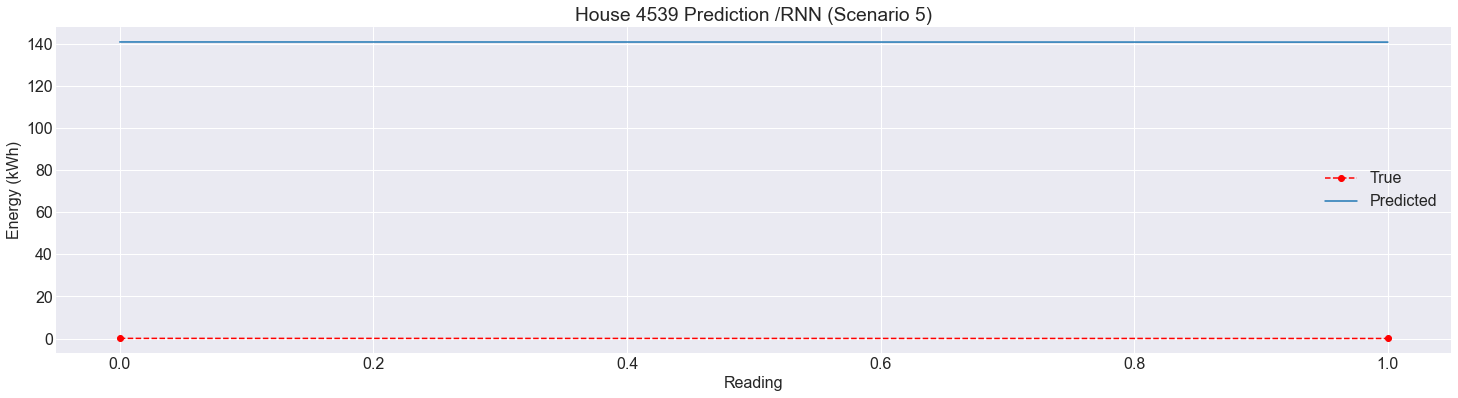

Mse:  13302.4898566919
Rmse: 115.336420339336
Mae:  115.336414798163
Mape:  99.8204139396944


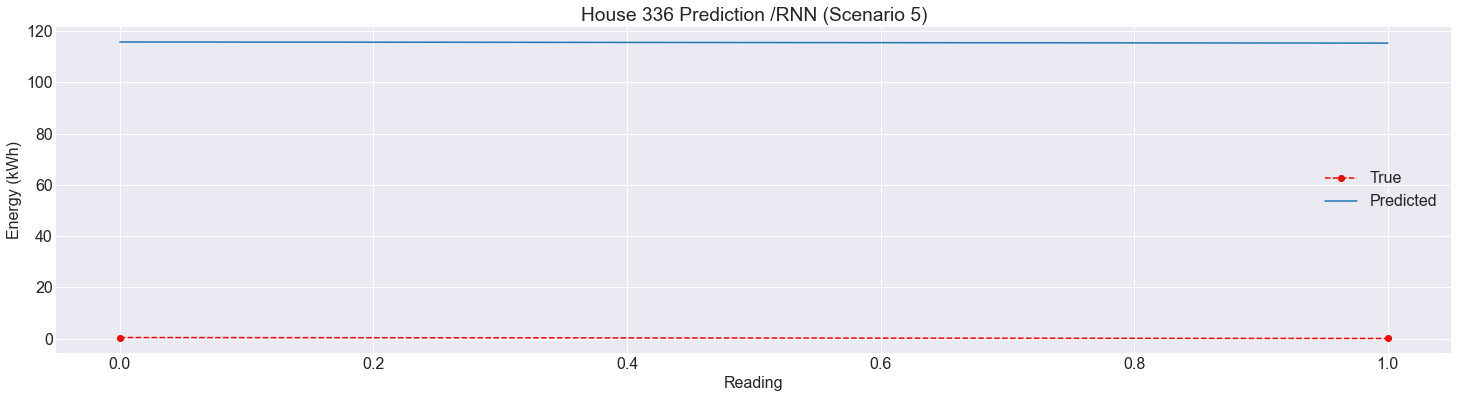

Mse:  16289.7694742691
Rmse: 127.6313812284
Mae:  127.60205450654
Mape:  99.7879661188337


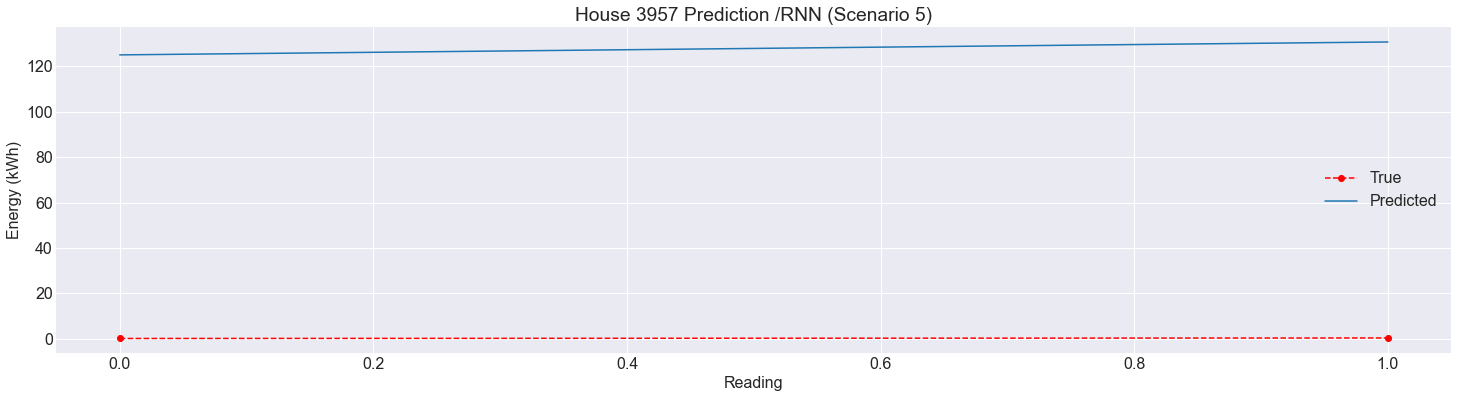

Mse:  29255.8080261374
Rmse: 171.043292841717
Mae:  171.041535280645
Mape:  99.9319326934781


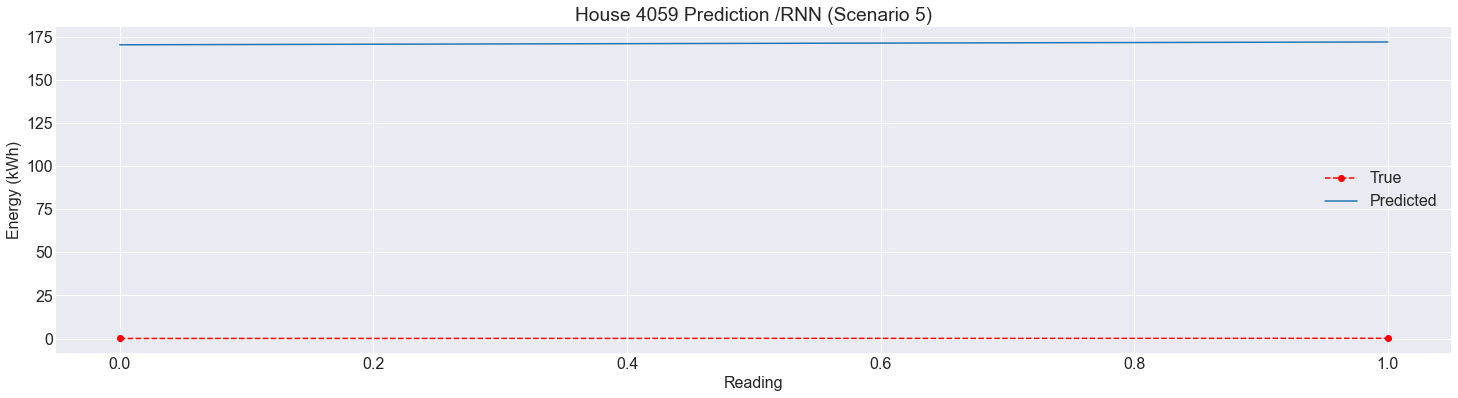

Mse:  9584.89485610055
Rmse: 97.9024762511171
Mae:  97.9024589536712
Mape:  99.987233815282


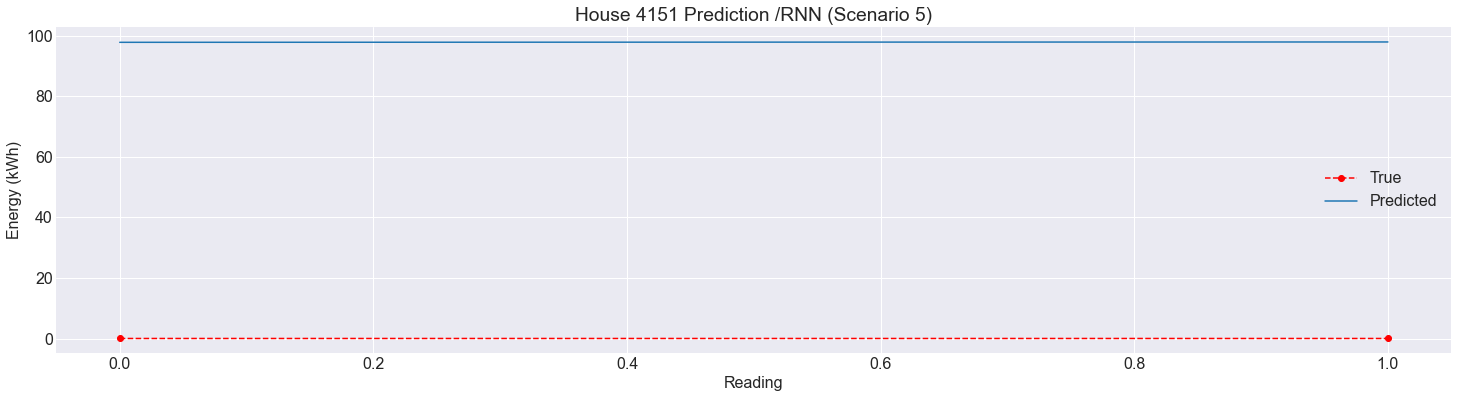

Mse:  12803.1211122768
Rmse: 113.150877646958
Mae:  113.150776460767
Mape:  100.166870106068


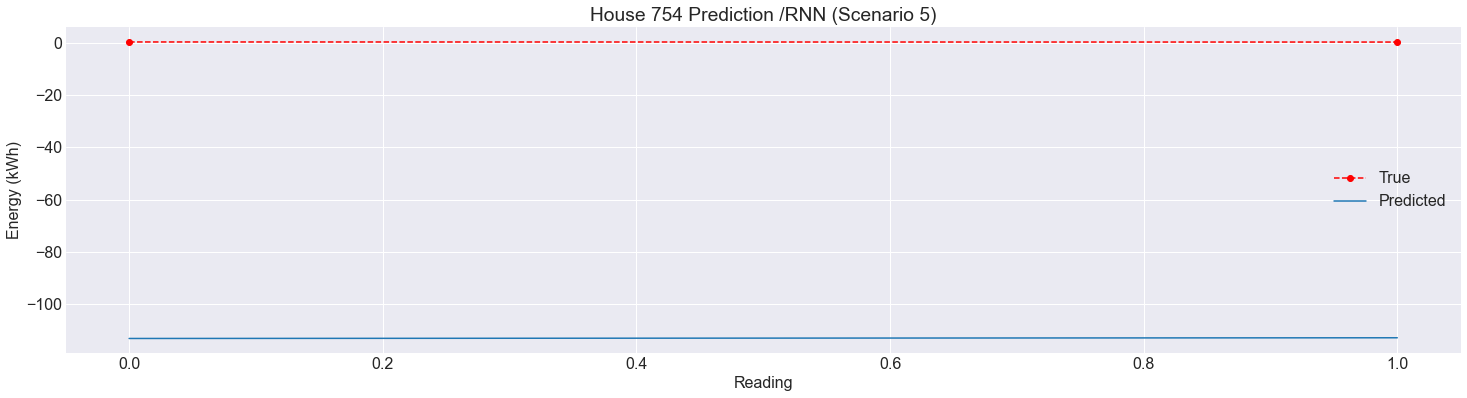

Mse:  15816.3313639327
Rmse: 125.762996799268
Mae:  125.76297512278
Mape:  100.145723918143


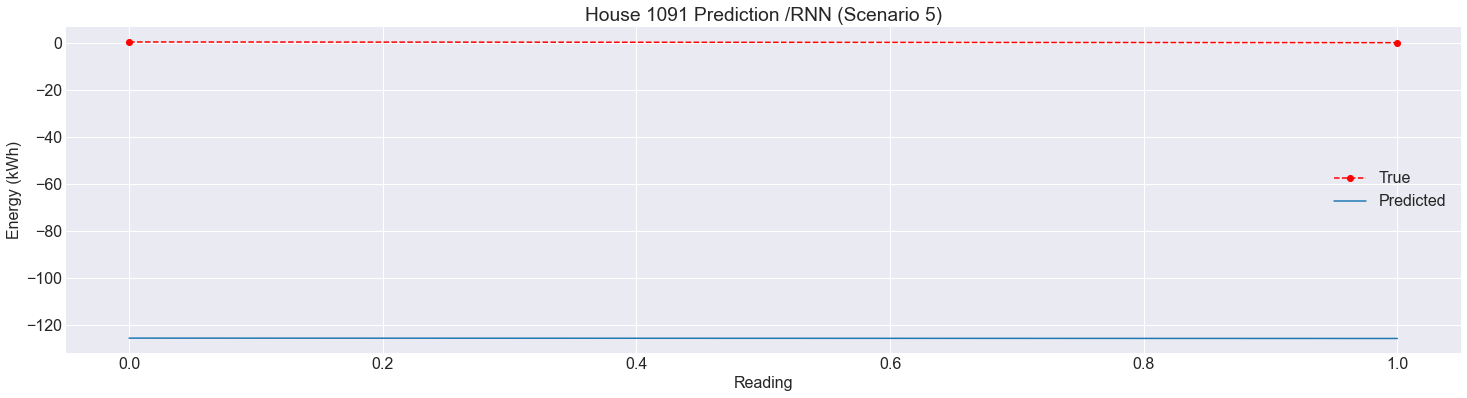

Mse:  10286.9962277122
Rmse: 101.424830429793
Mae:  101.424816987477
Mape:  99.9467869246081


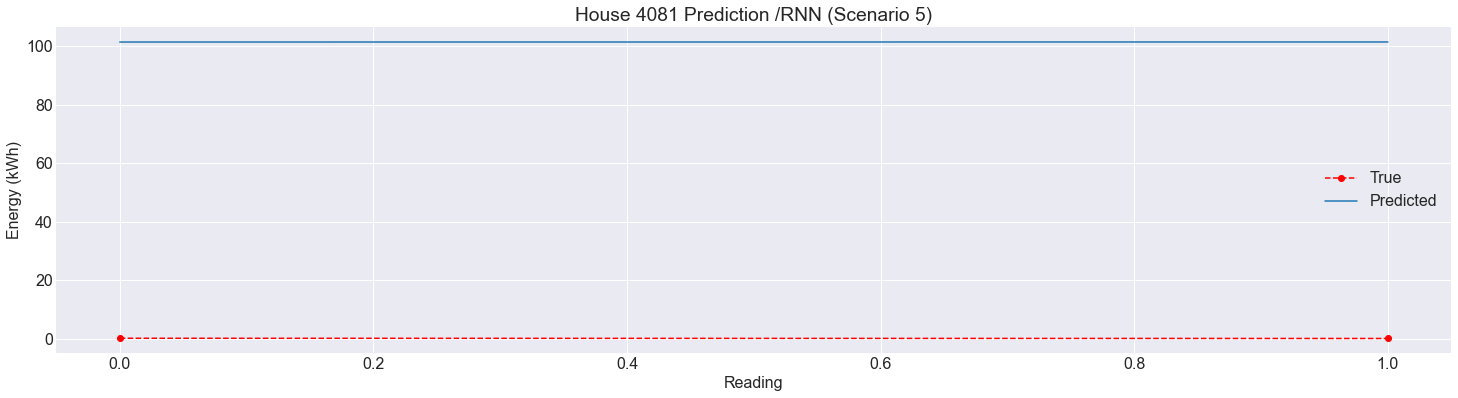

Mse:  1250.43421259255
Rmse: 35.36147921952
Mae:  35.3607287295163
Mape:  99.860204493865


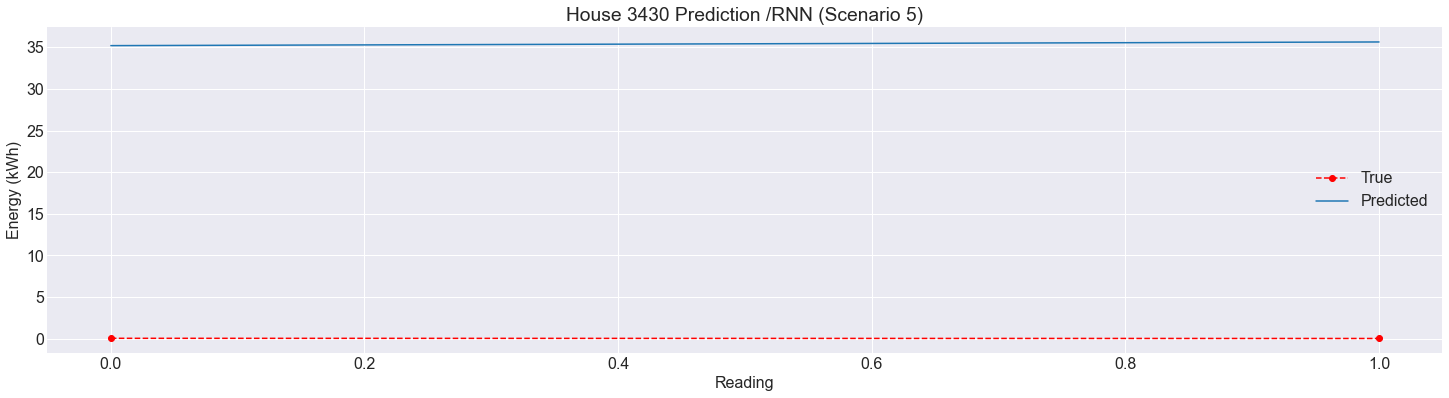

Mse:  616.446719710911
Rmse: 24.8283450860284
Mae:  24.8282856270671
Mape:  100.382068995292


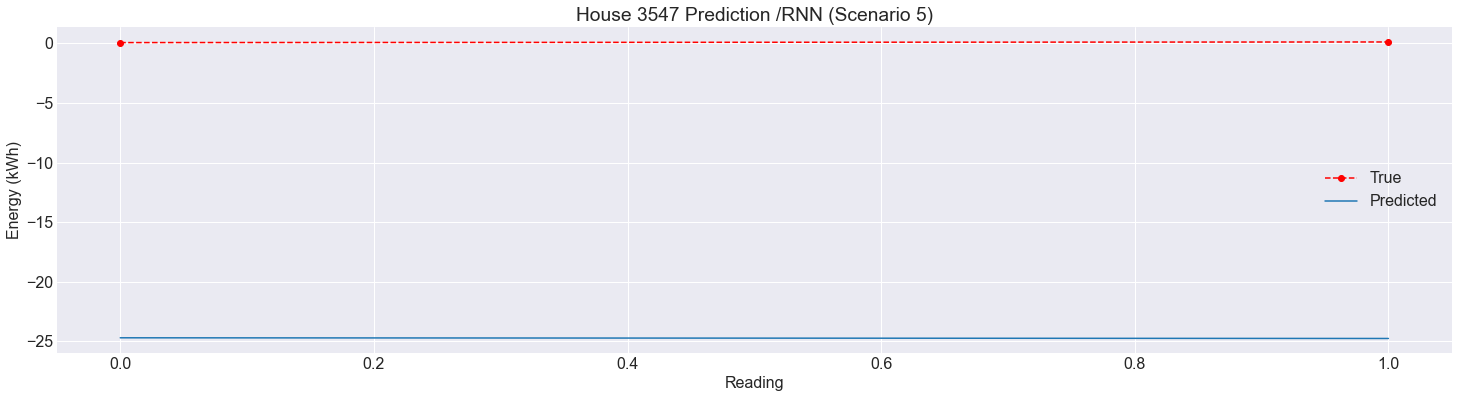

Mse:  7252.65047248913
Rmse: 85.1624945177696
Mae:  85.1623223908246
Mape:  99.7627827871138


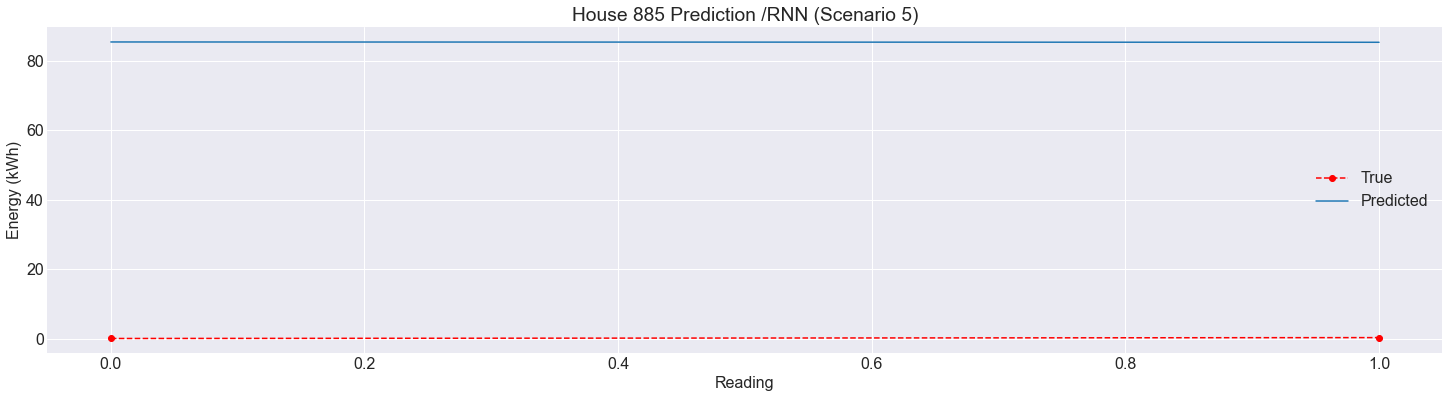

Mse:  367.930316735883
Rmse: 19.1815097616398
Mae:  19.1812151484191
Mape:  100.489852204819


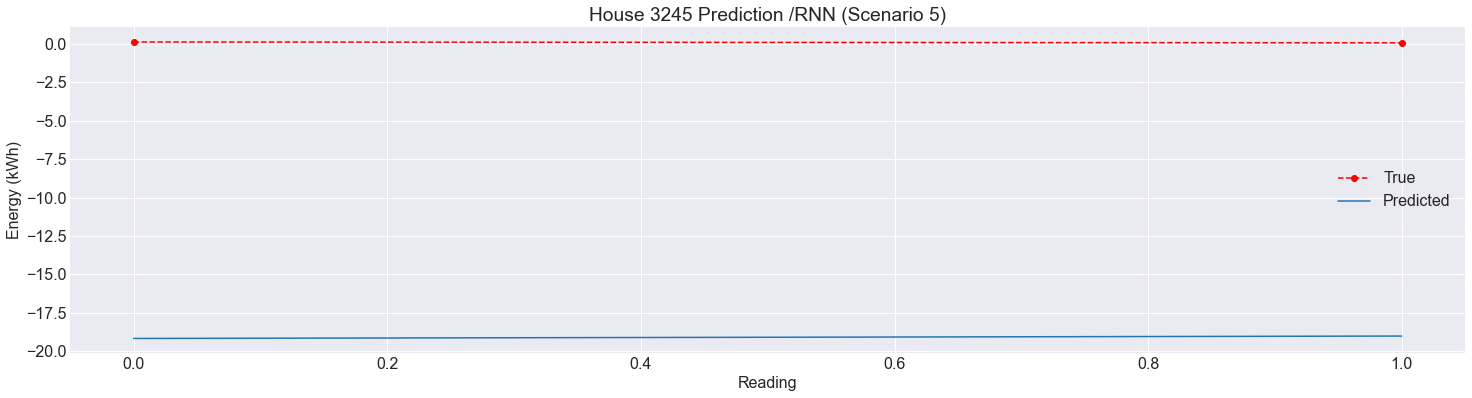

Mse:  998.644369150114
Rmse: 31.6013349267102
Mae:  31.5881379321218
Mape:  100.727639813372


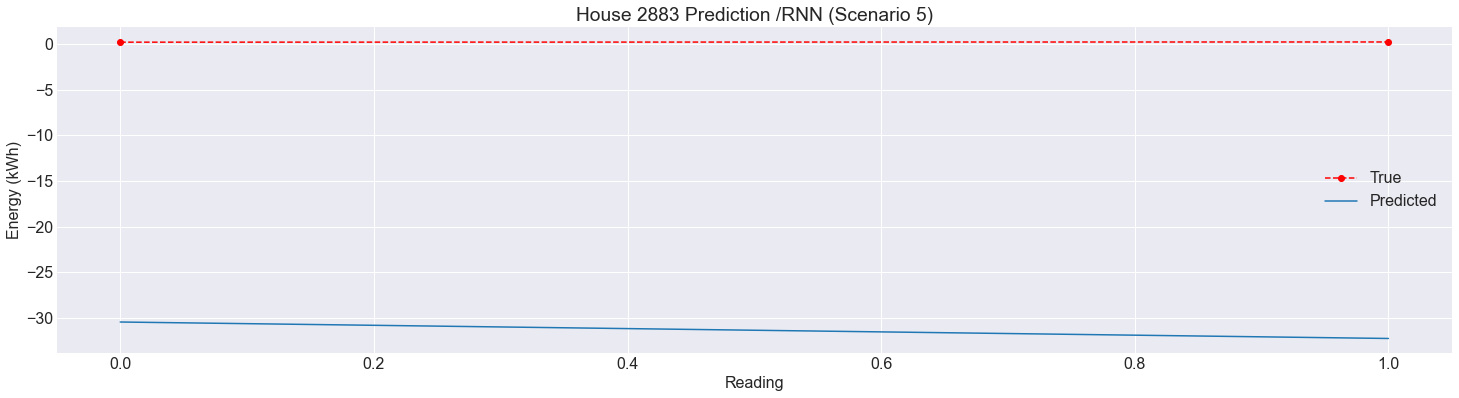

Mse:  28328.7715199324
Rmse: 168.31153115557
Mae:  168.311530822888
Mape:  99.9667394296924


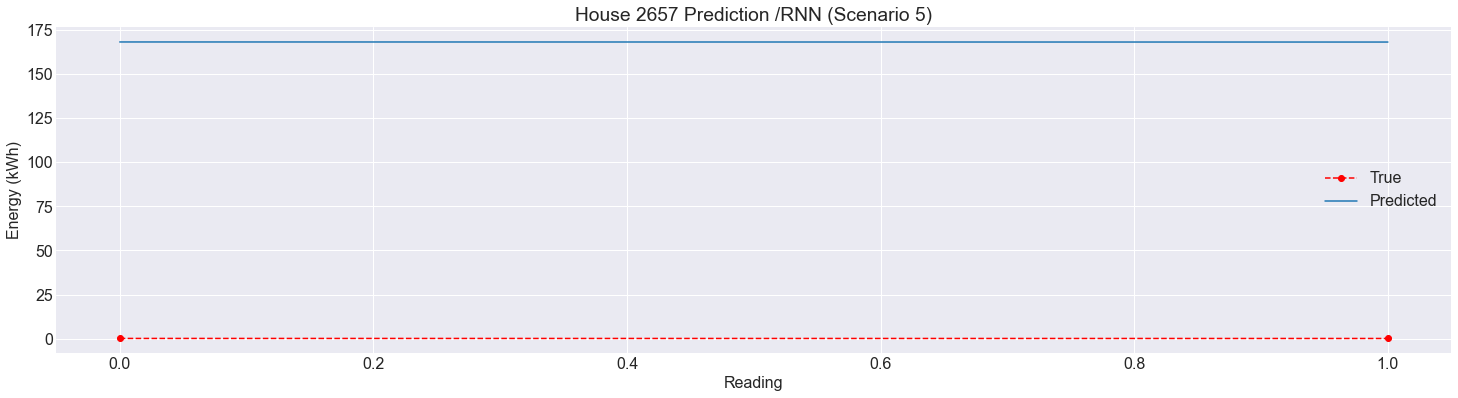

Mse:  134.34261404851
Rmse: 11.590626128407
Mae:  11.5772719420493
Mape:  101.241096863495


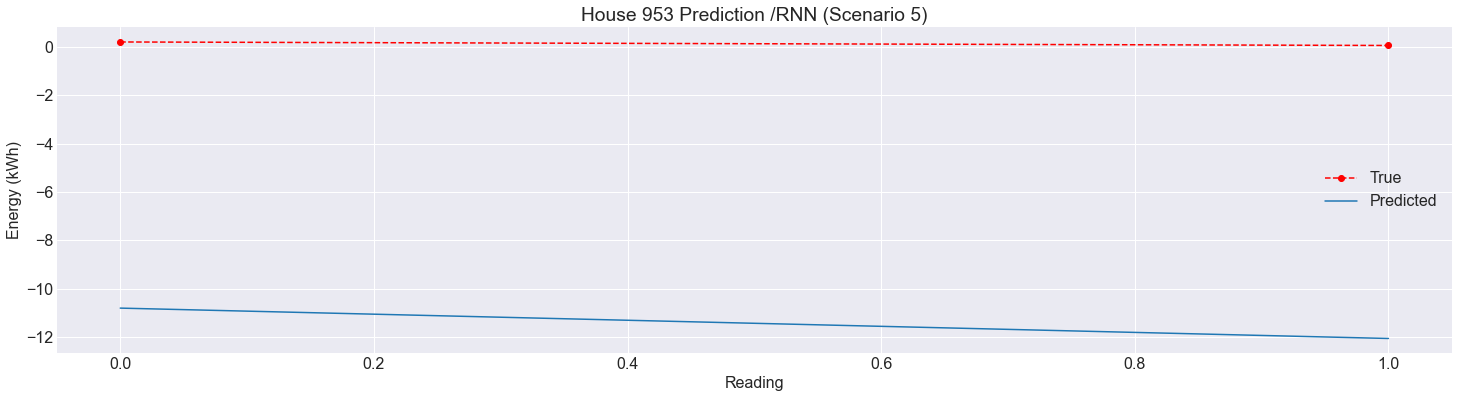

Mse:  7553.95907743331
Rmse: 86.9135149296892
Mae:  86.9122234769166
Mape:  100.127305845152


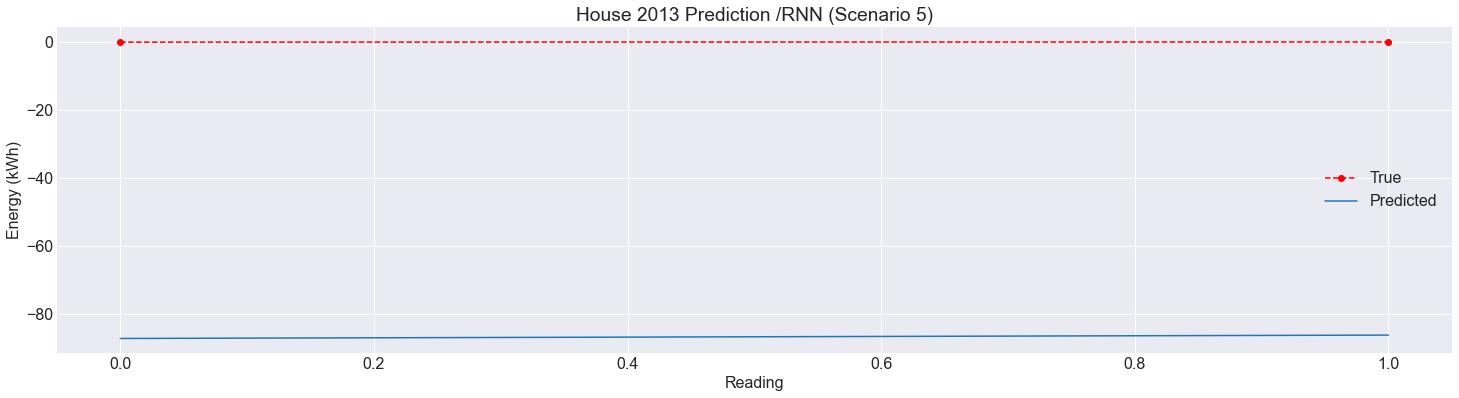

Mse:  6313.72711854795
Rmse: 79.4589649979658
Mae:  79.4589649653062
Mape:  99.981754915906


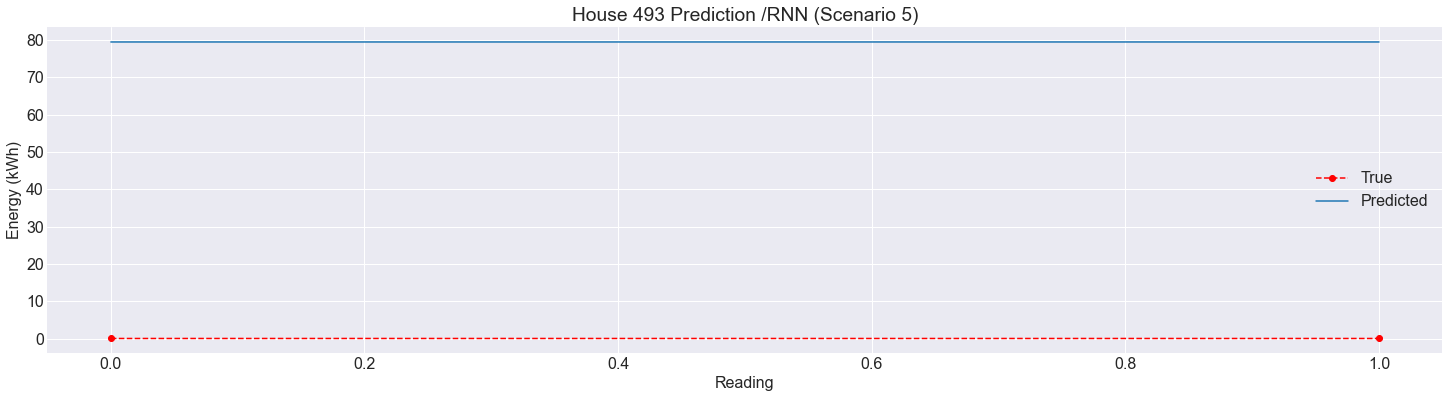

Mse:  43374.105423643
Rmse: 208.26450831489
Mae:  208.264166988432
Mape:  100.15292435584


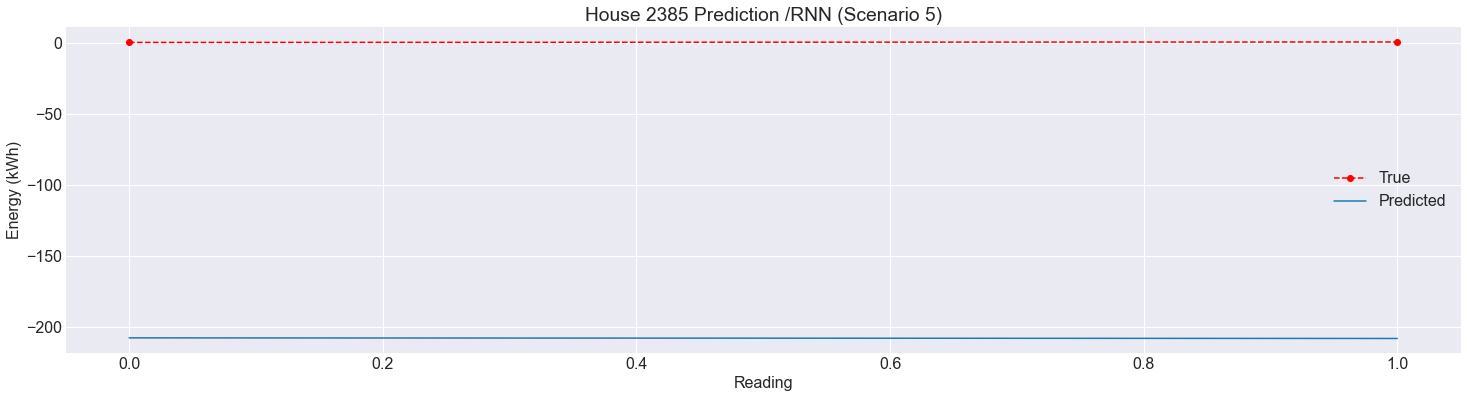

Mse:  27931.3787599397
Rmse: 167.126834350261
Mae:  167.121919739991
Mape:  100.089540379642


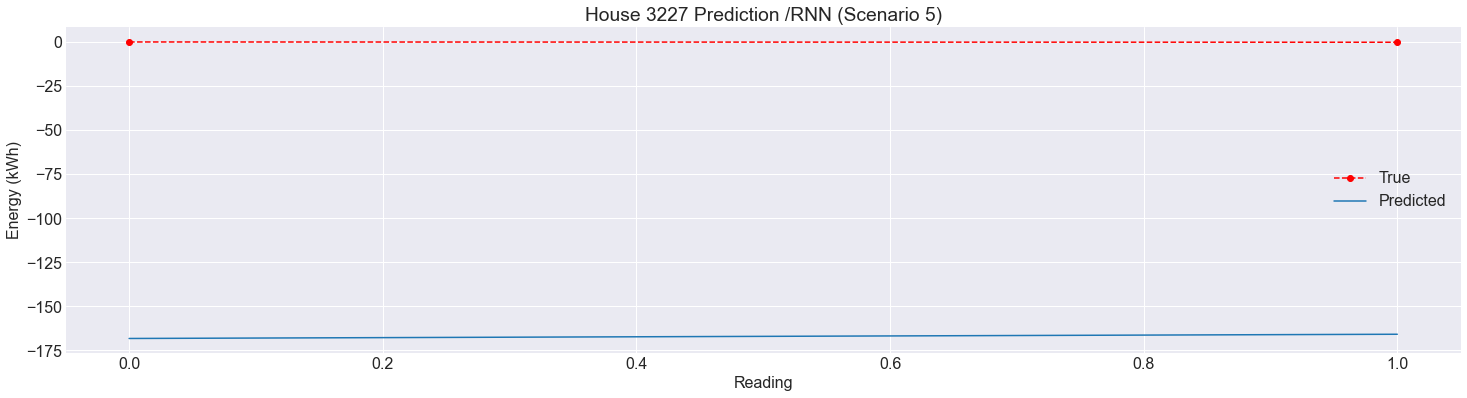

Mse:  20170.0086418376
Rmse: 142.021155613654
Mae:  142.021053215489
Mape:  100.205673447253


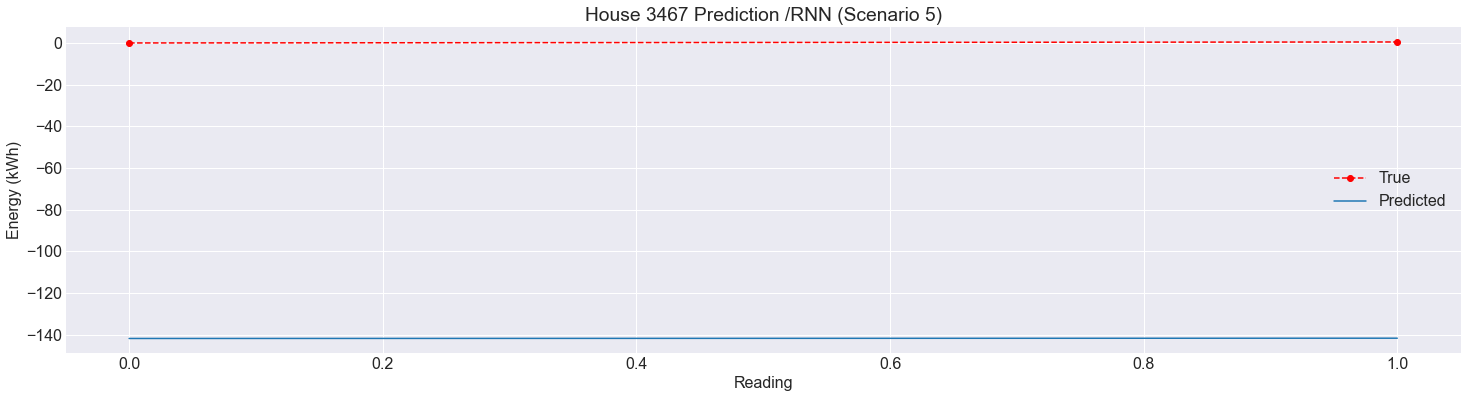

Mse:  2356.21873827692
Rmse: 48.5408975841704
Mae:  48.5408638715744
Mape:  98.9834649828239


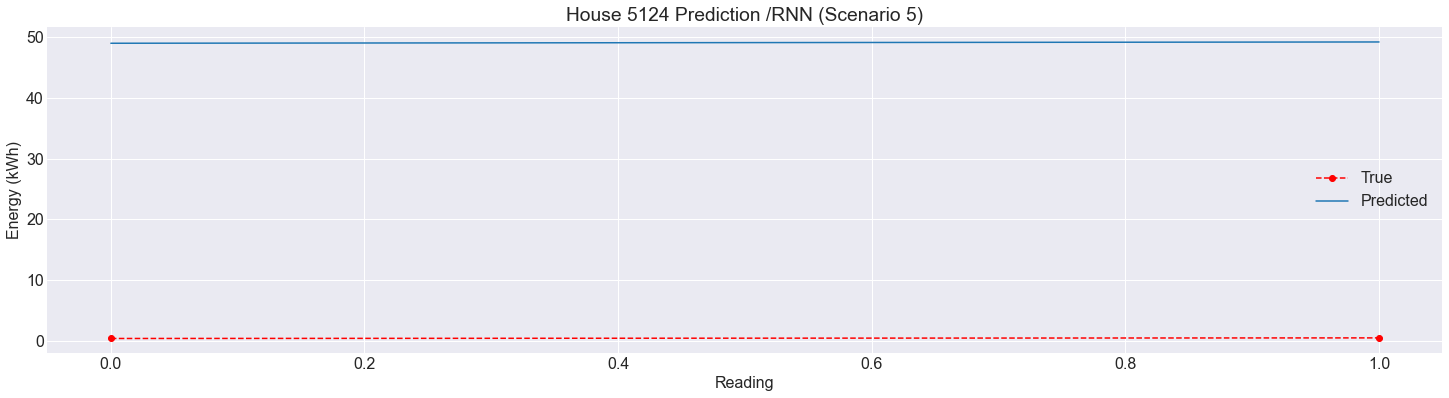

Mse:  7570.42572371589
Rmse: 87.0081934286415
Mae:  87.008173853159
Mape:  100.374349609824


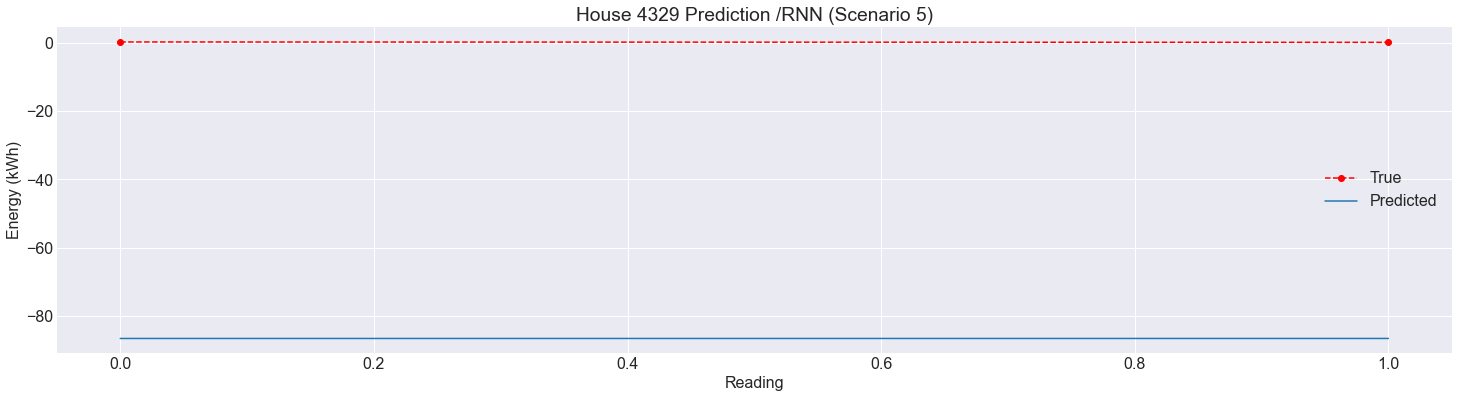

In [129]:
 ##### The households with an error have a '#' 

predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)



In [130]:
models_performances_HH_level = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level

,HH_1,HH_2,HH_3,HH_4,HH_5,HH_6,HH_7,HH_8,HH_9,HH_10,...,HH_20,HH_21,HH_22,HH_23,HH_24,HH_25,HH_26,HH_27,HH_28,HH_29
MSE_scores,19351.862330,18343.813905,95.053752,231.780283,639.743425,37639.761063,16817.275467,19833.045398,13302.489857,16289.769474,...,998.644369,28328.771520,134.342614,7553.959077,6313.727119,43374.105424,27931.378760,20170.008642,2356.218738,7570.425724
RMSE_scores,139.110971,135.439337,9.749551,15.224332,25.293150,194.009693,129.681438,140.829846,115.336420,127.631381,...,31.601335,168.311531,11.590626,86.913515,79.458965,208.264508,167.126834,142.021156,48.540898,87.008193
MAE_scores,139.110958,135.437117,9.748931,15.223923,25.293137,194.009693,129.681414,140.829845,115.336415,127.602055,...,31.588138,168.311531,11.577272,86.912223,79.458965,208.264167,167.121920,142.021053,48.540864,87.008174
MAPE_scores,100.089577,99.885683,96.740191,98.988905,100.170296,100.053118,100.083737,99.950674,99.820414,99.787966,...,100.727640,99.966739,101.241097,100.127306,99.981755,100.152924,100.089540,100.205673,98.983465,100.374350


In [131]:
models_performances_HH_level.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario1_1h.csv', index=False)

In [ ]:
## Best regression model

In [132]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                      'HH_2',
                      'HH_3',
                      'HH_4',
                      'HH_5',
                      'HH_6',
                      'HH_7',
                      'HH_8',
                      'HH_9',
                      'HH_10',
                      'HH_11',
                      'HH_12',
                      'HH_13',
                      'HH_14',
                      'HH_15',
                      'HH_16',
                      'HH_17',
                      'HH_18',
                      'HH_19',
                      'HH_20',
                      'HH_21',
                      'HH_22',
                      'HH_23',
                      'HH_24',
                      'HH_25',
                      'HH_26',
                      'HH_27',
                      'HH_28', 
                      'HH_29']

In [133]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-2), :]
  test = reframed[(len(reframed)-2):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]


  model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
  model.fit(train_X, train_y)

  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15f}')
  print(f'Rmse: {rmse_HH:.15f}')
  print(f'Mae:  {mae_HH:.15f}')
  print(f'Mape:  {mape_HH:.15f}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /SVR (Scenario 5)')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario5/2_singleHouseholdLevel/best_NN_model/S5_1h_SVR_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


Mse:  0.001184908281015
Rmse: 0.034422496728381
Mae:  0.032032692983072
Mape:  33.245430055114547


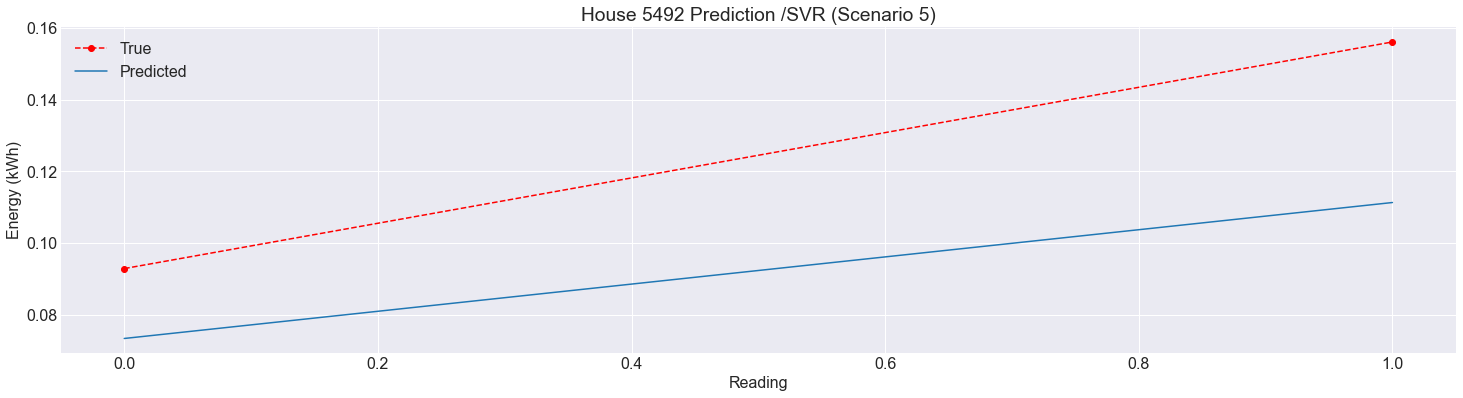

Mse:  0.016664915742930
Rmse: 0.129092663396996
Mae:  0.122330958668801
Mape:  179.639572563254973


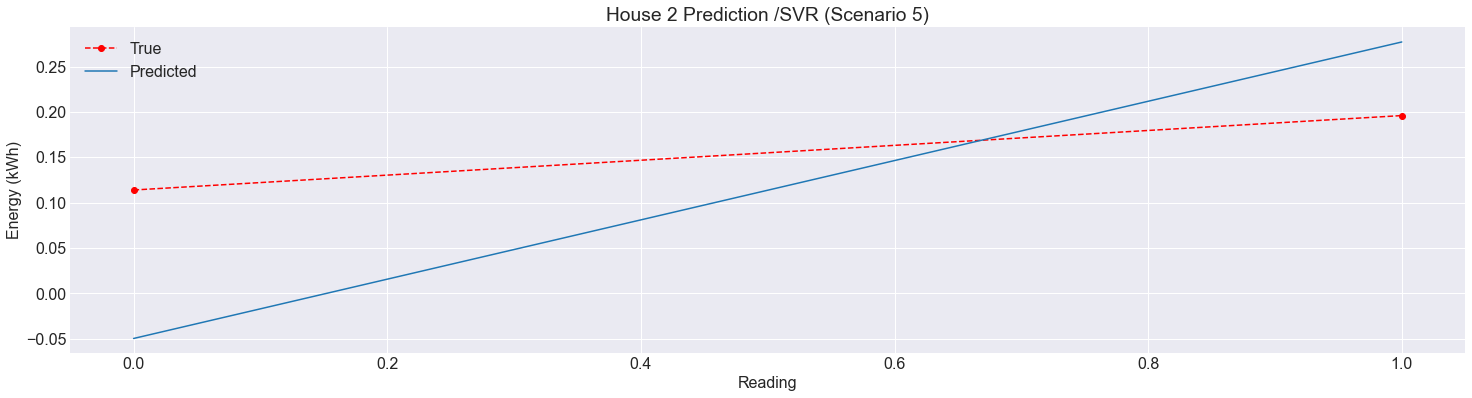

Mse:  0.095310184403533
Rmse: 0.308723475627516
Mae:  0.295603347663802
Mape:  46.773869664965105


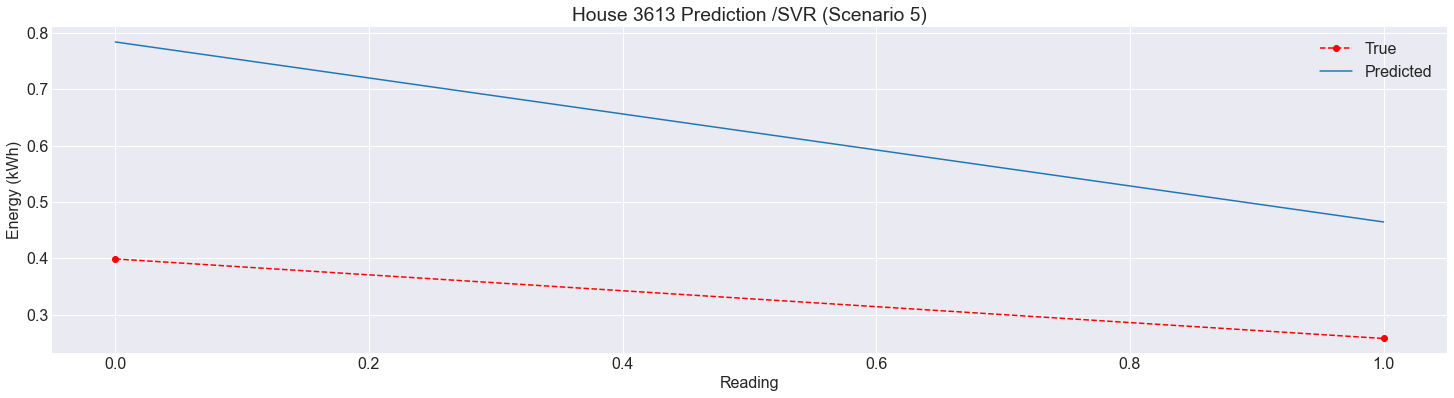

Mse:  0.008330984898112
Rmse: 0.091274229101714
Mae:  0.072468490732332
Mape:  73.046053353160971


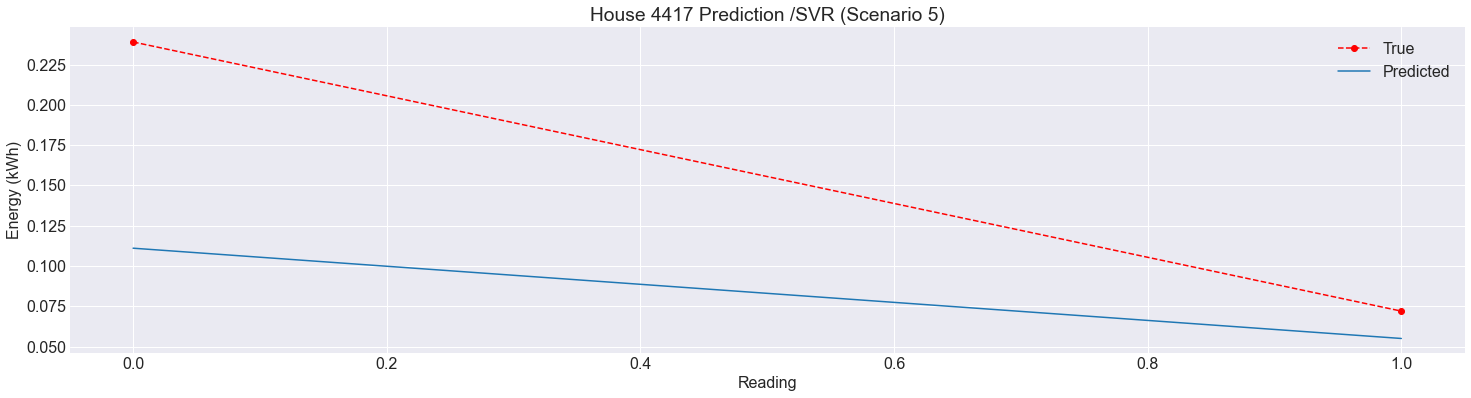

Mse:  0.000139311002377
Rmse: 0.011803008191839
Mae:  0.011802949630930
Mape:  27.472655727754979


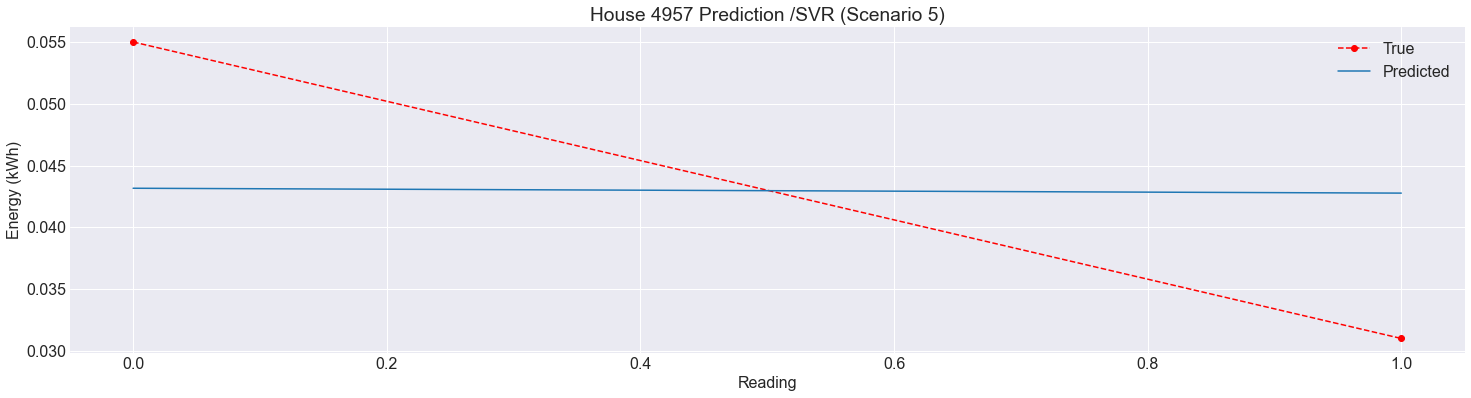

Mse:  0.034404807595796
Rmse: 0.185485329866802
Mae:  0.166050937598872
Mape:  313.652962982502515


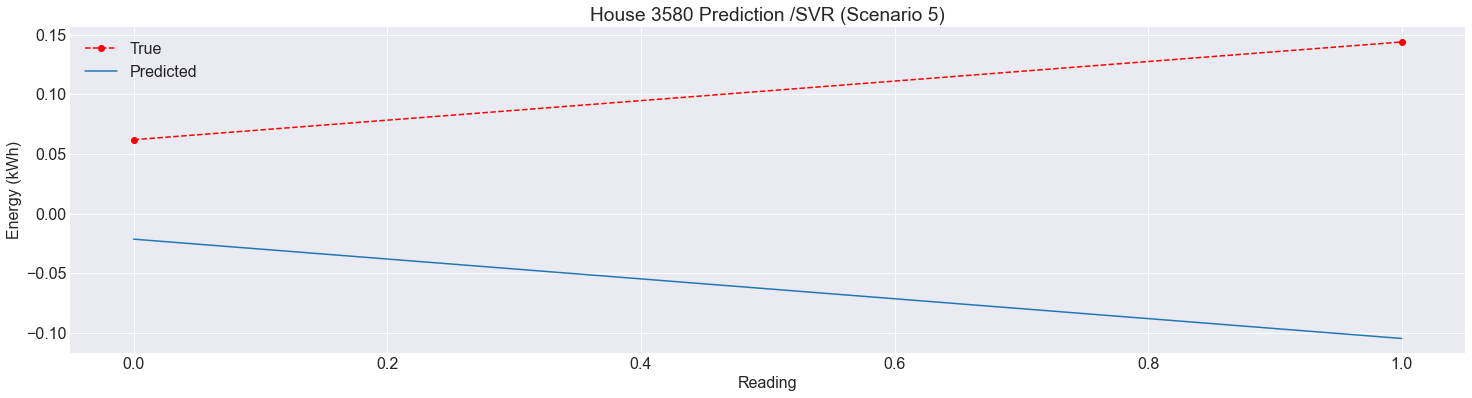

Mse:  0.021092468391389
Rmse: 0.145232463283486
Mae:  0.141128118295684
Mape:  176.324800508219624


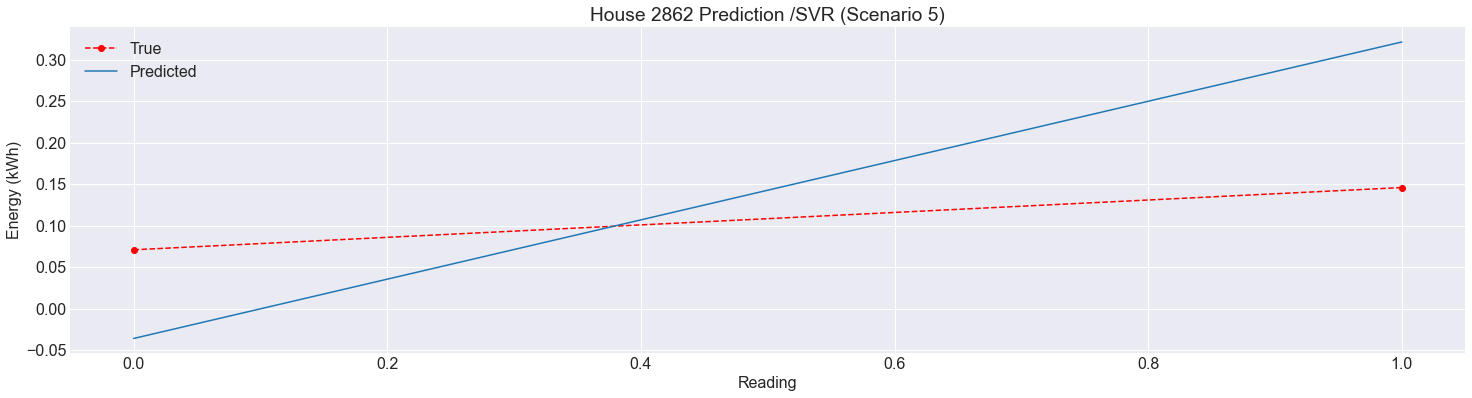

Mse:  0.001655595261911
Rmse: 0.040689006646900
Mae:  0.040060944440961
Mape:  38.745608943783679


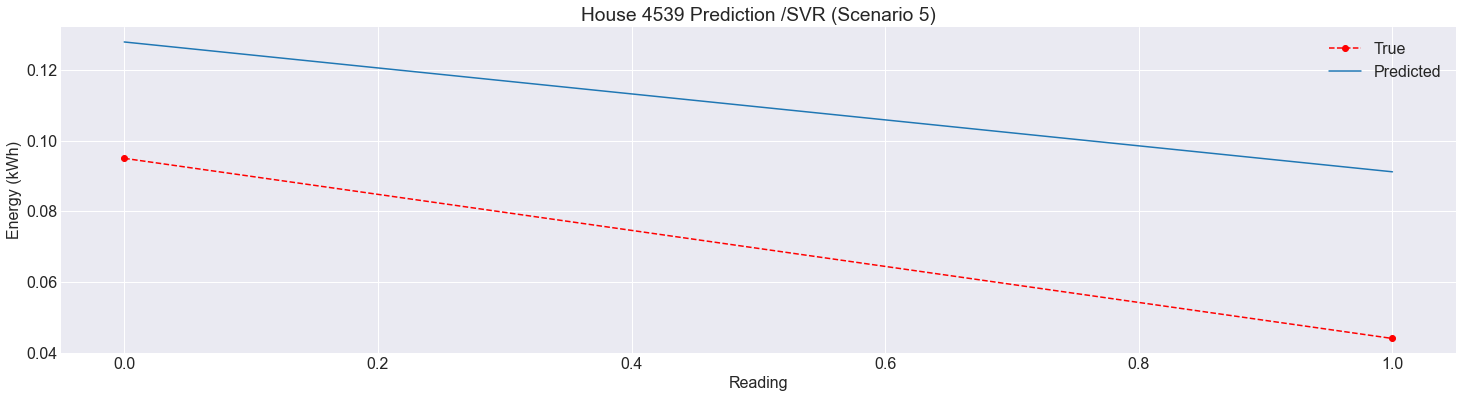

Mse:  0.016714056364554
Rmse: 0.129282854101207
Mae:  0.110906535309397
Mape:  74.889263073400542


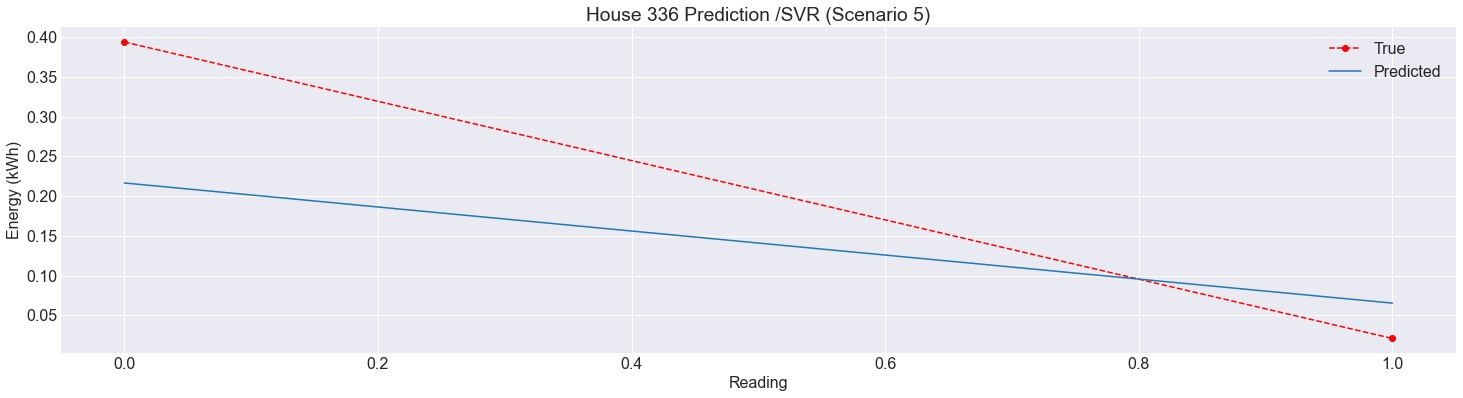

Mse:  0.009877060150621
Rmse: 0.099383399773913
Mae:  0.076169223440788
Mape:  32.705782188183910


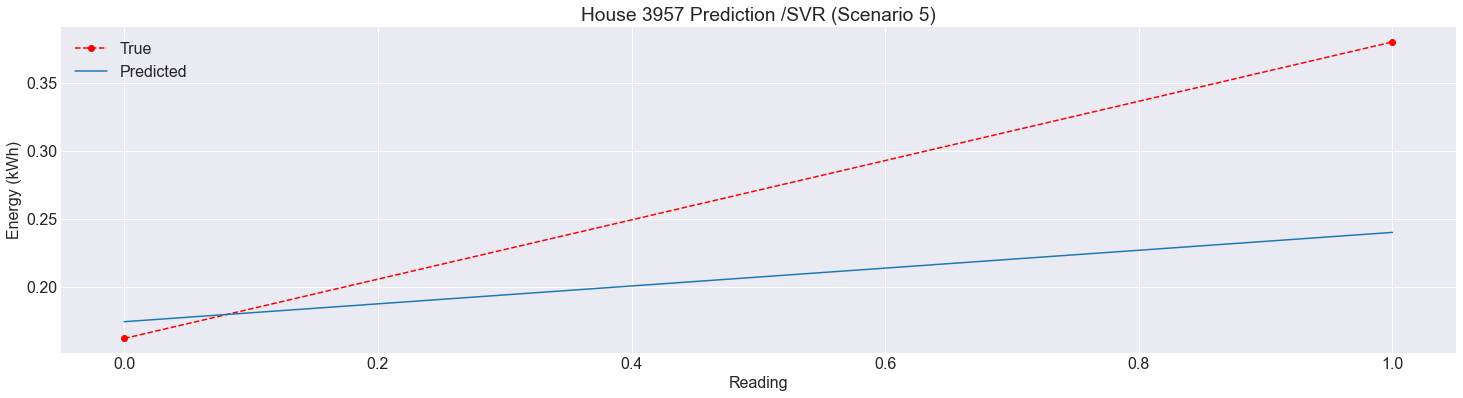

Mse:  0.017719961322429
Rmse: 0.133116345061111
Mae:  0.130085302099591
Mape:  53.992680718058160


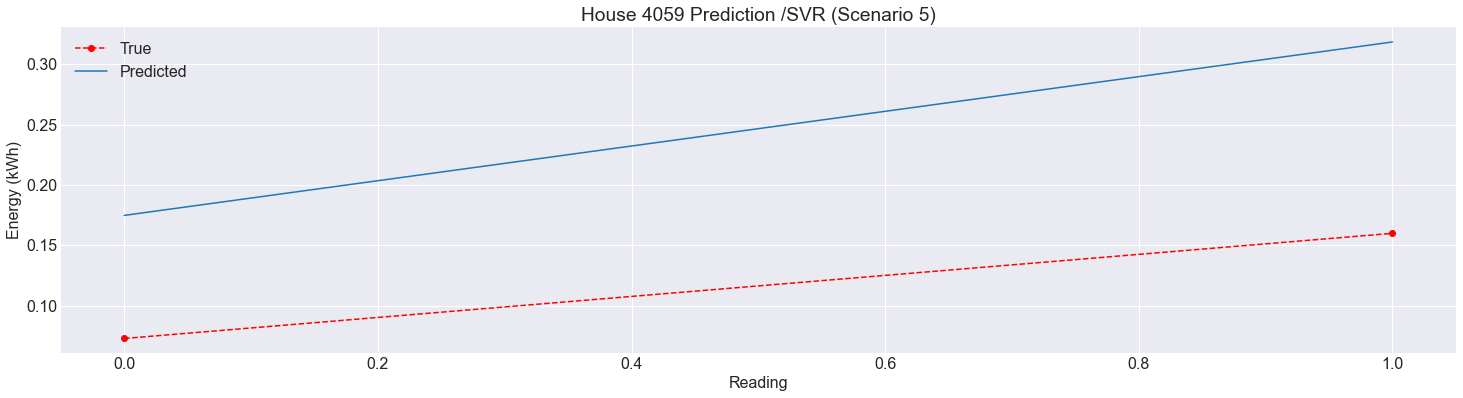

Mse:  0.003552121904888
Rmse: 0.059599680409278
Mae:  0.059599621305851
Mape:  82.666301489167736


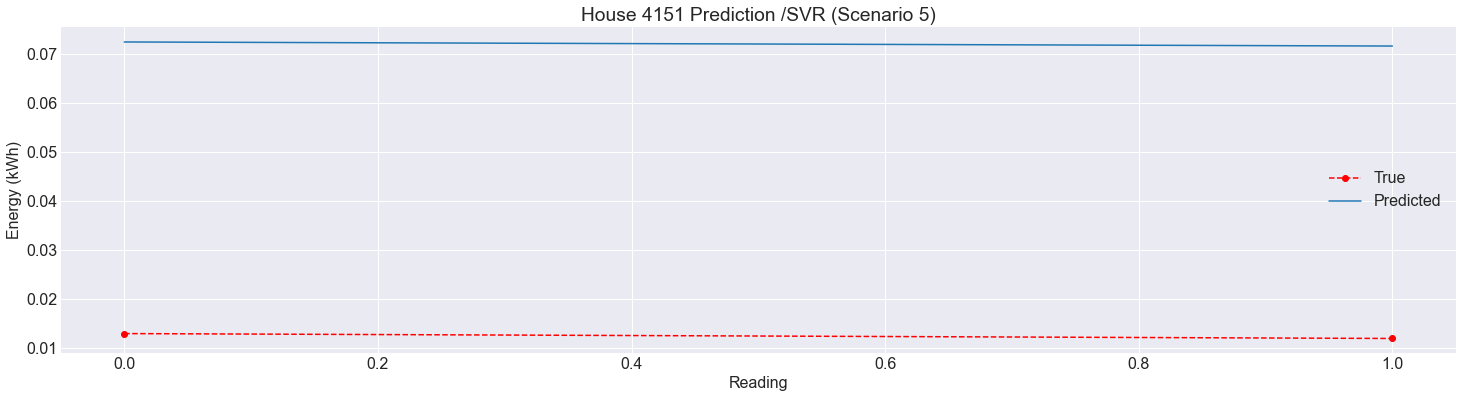

Mse:  0.016189488331134
Rmse: 0.127237920177650
Mae:  0.110443113585341
Mape:  287.458977990847984


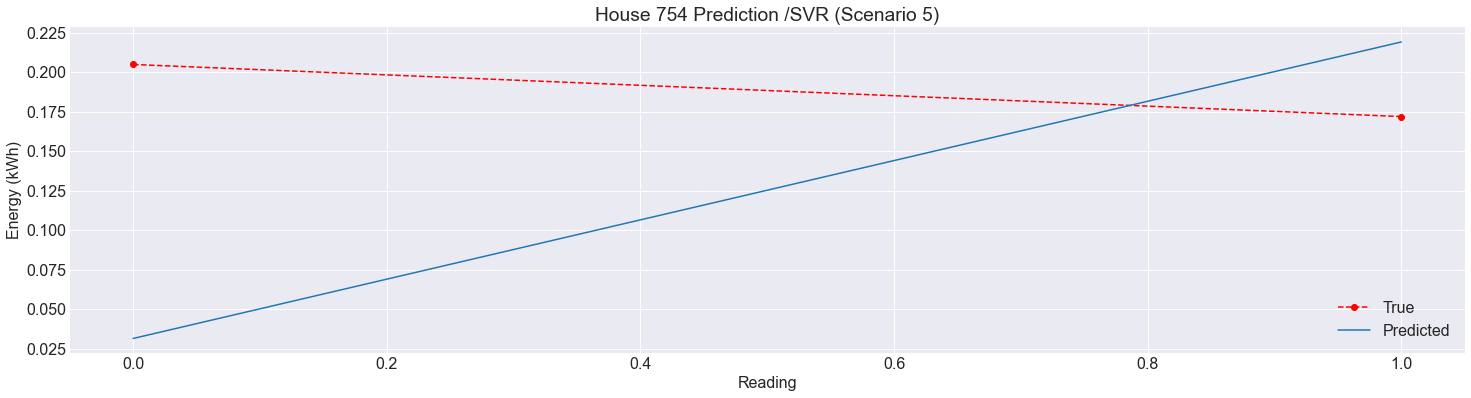

Mse:  0.004510932326697
Rmse: 0.067163474647287
Mae:  0.067128852053466
Mape:  46.009898564283787


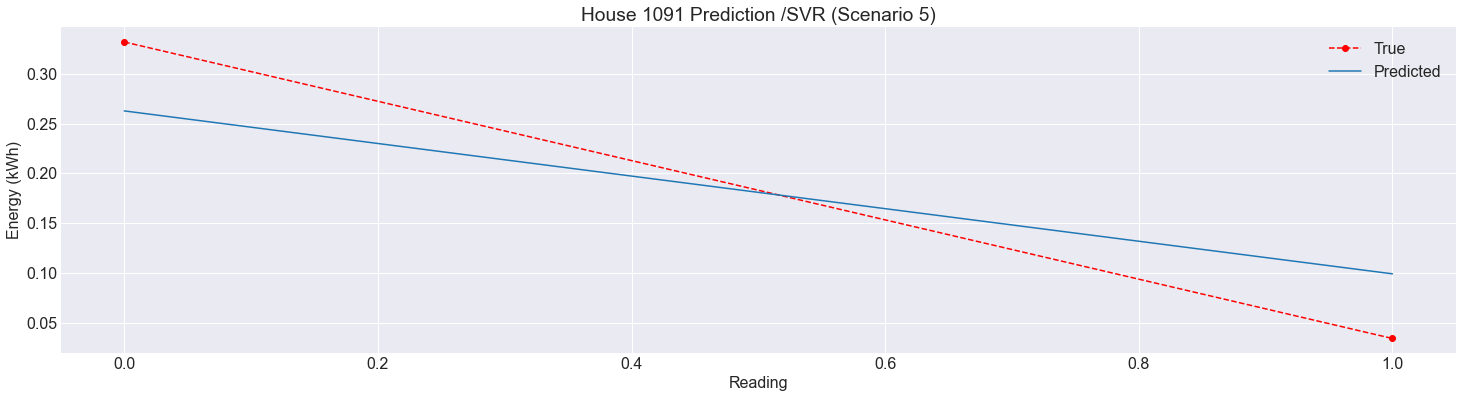

Mse:  0.004336135457189
Rmse: 0.065849339079360
Mae:  0.052416311558389
Mape:  49.305941743860210


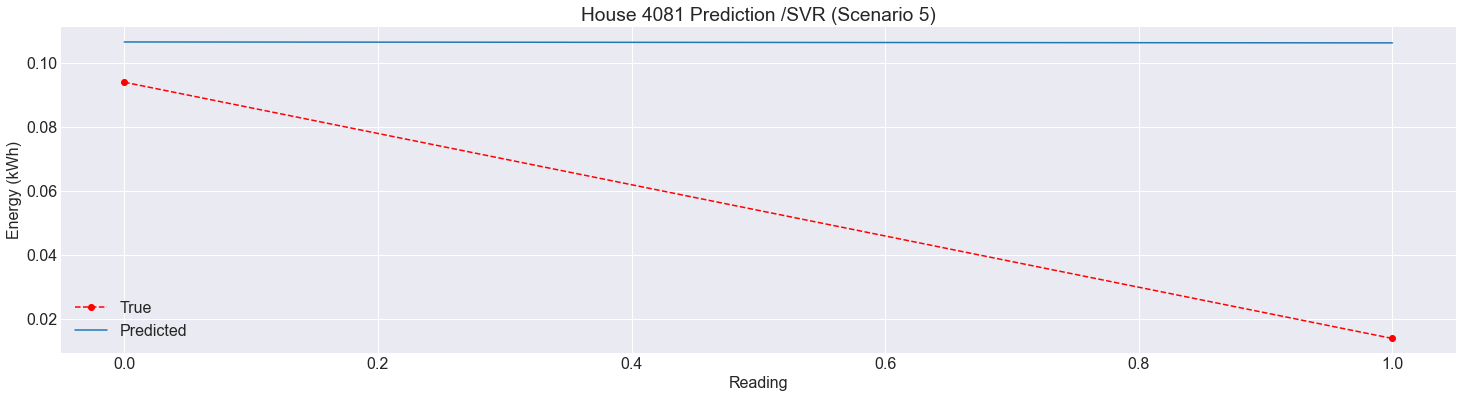

Mse:  0.019401770533922
Rmse: 0.139290238473204
Mae:  0.138870983613282
Mape:  73.713150719492731


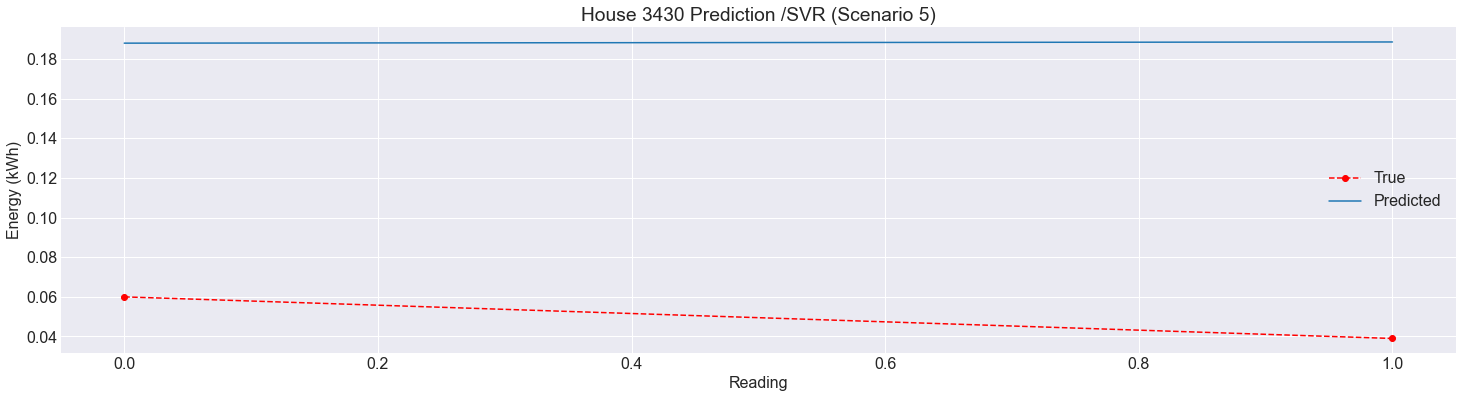

Mse:  0.012652857248874
Rmse: 0.112484920095422
Mae:  0.107073035003898
Mape:  354.140474013351081


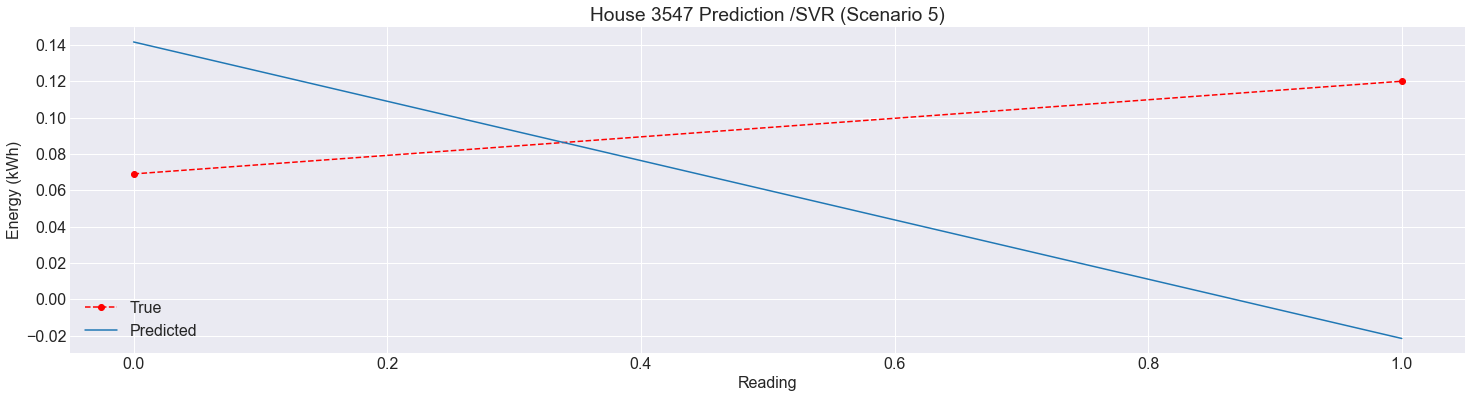

Mse:  0.158182566615301
Rmse: 0.397721720069826
Mae:  0.393045830084391
Mape:  69.678835865985775


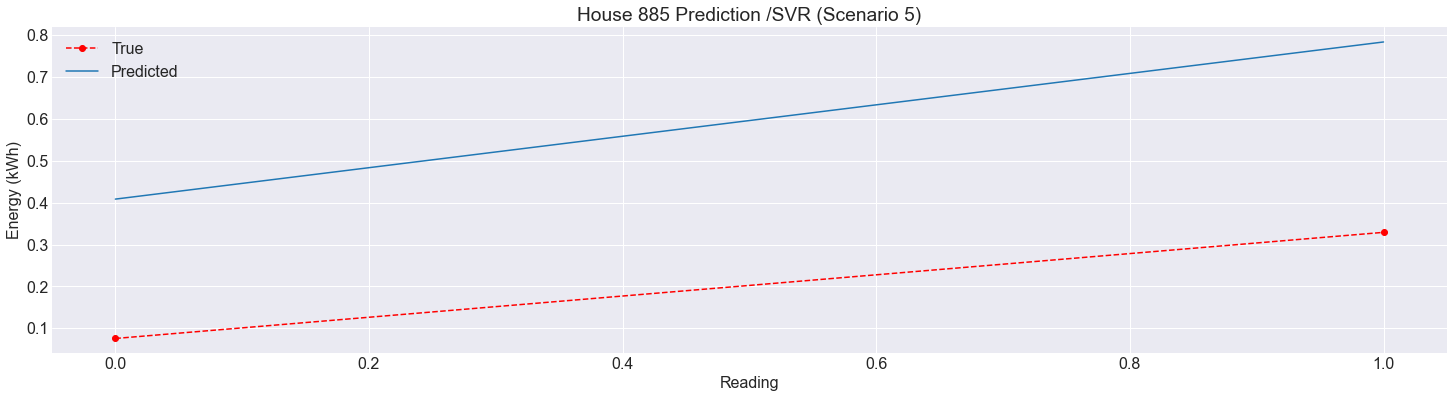

Mse:  0.018005049133881
Rmse: 0.134182894341569
Mae:  0.133001292498082
Mape:  1088.036840957735421


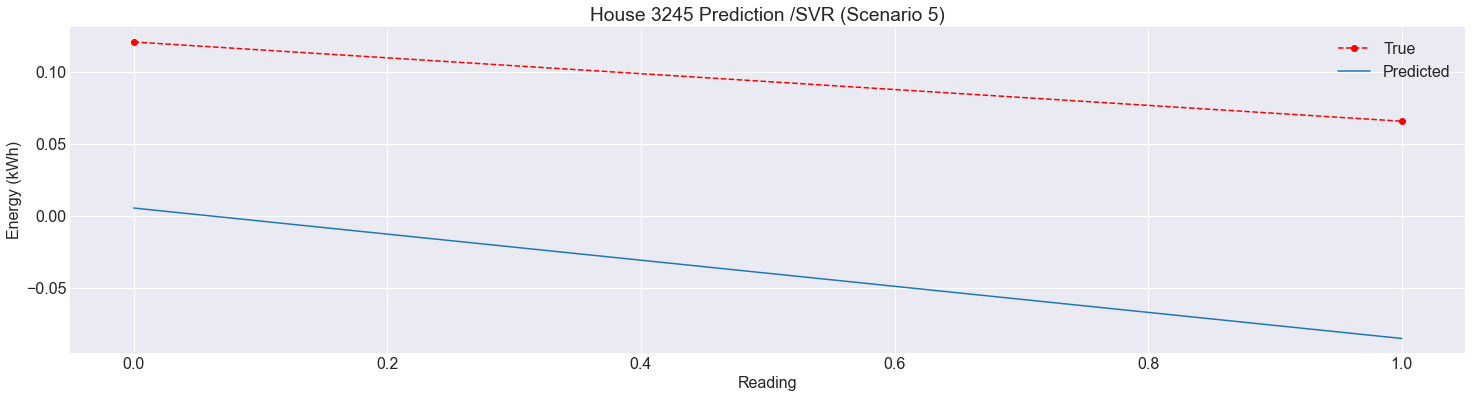

Mse:  0.004368541104449
Rmse: 0.066094940082042
Mae:  0.066086711176908
Mape:  22.509656705195486


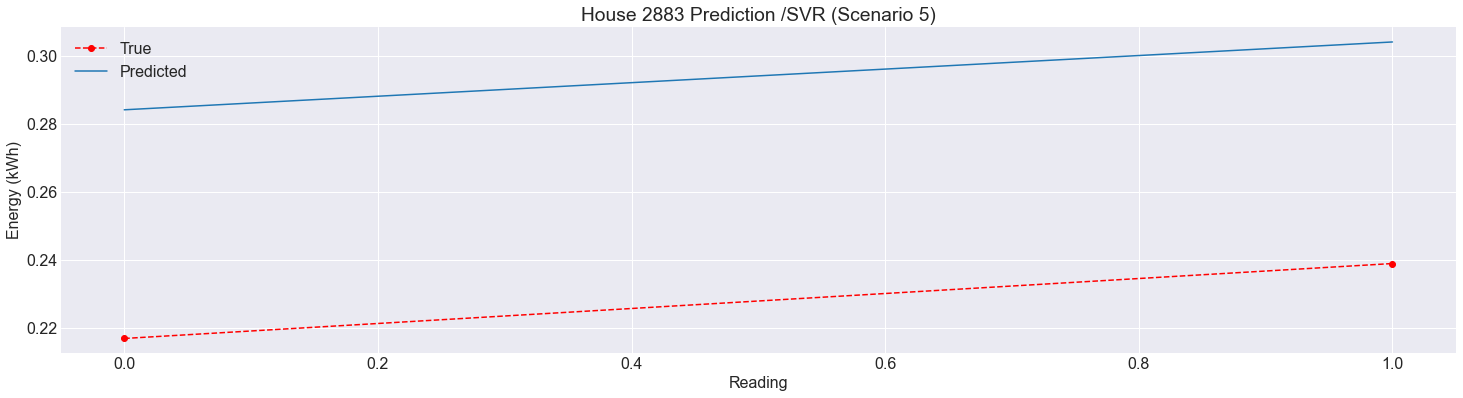

Mse:  0.035921533102069
Rmse: 0.189529768379717
Mae:  0.189234878318356
Mape:  77.215068132382299


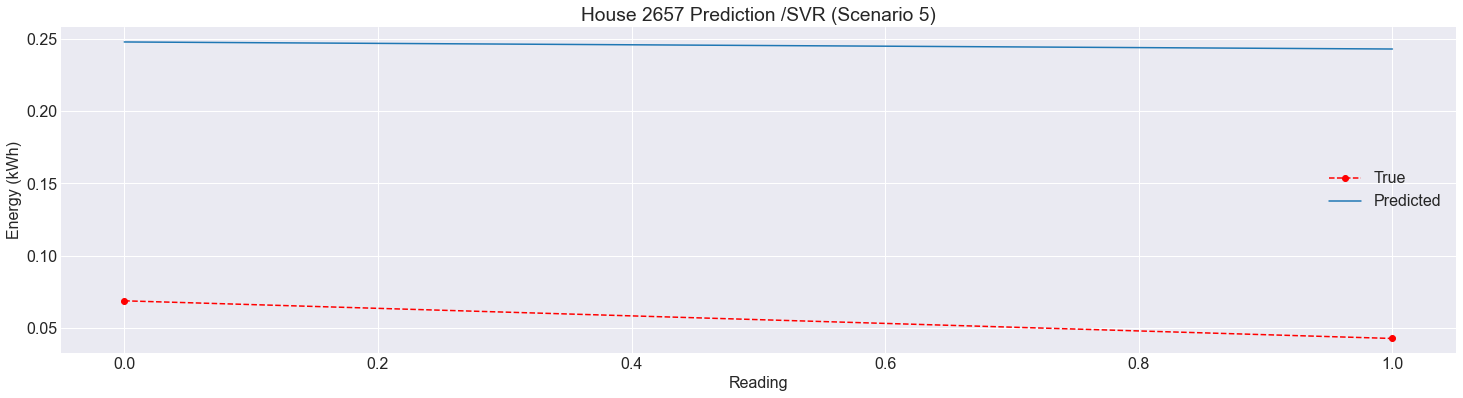

Mse:  0.006263066282625
Rmse: 0.079139536785511
Mae:  0.073111815280488
Mape:  65.896377016418327


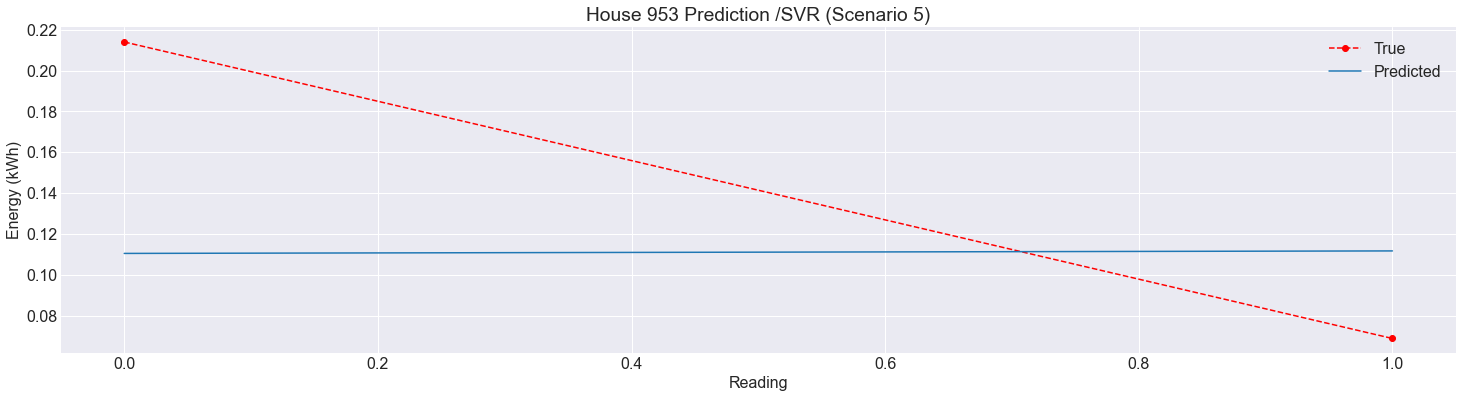

Mse:  0.002403628028602
Rmse: 0.049026809284329
Mae:  0.047705988697014
Mape:  30.169724971859651


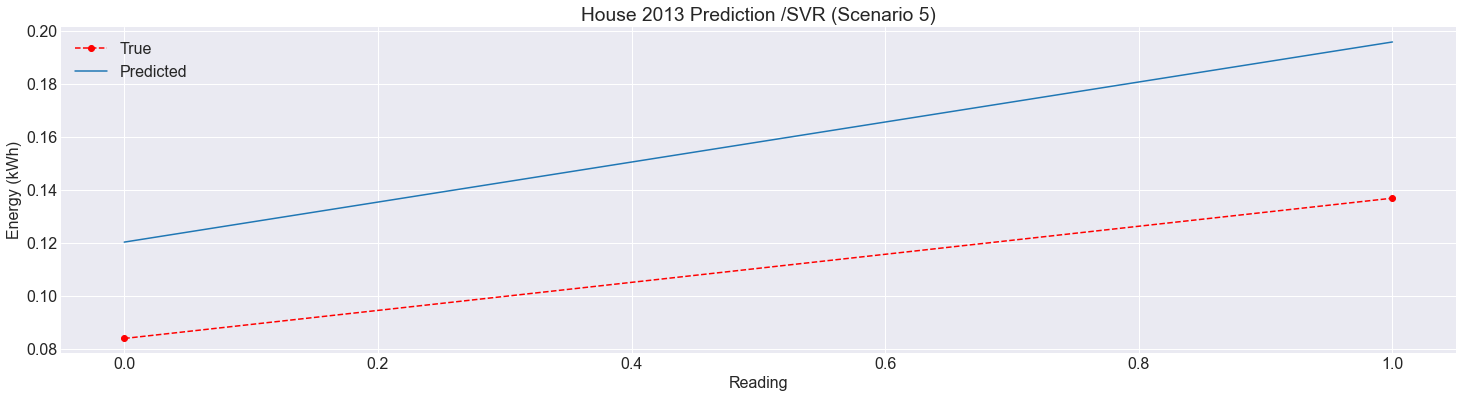

Mse:  0.004393121030543
Rmse: 0.066280623341538
Mae:  0.062236878553535
Mape:  116.665692633203363


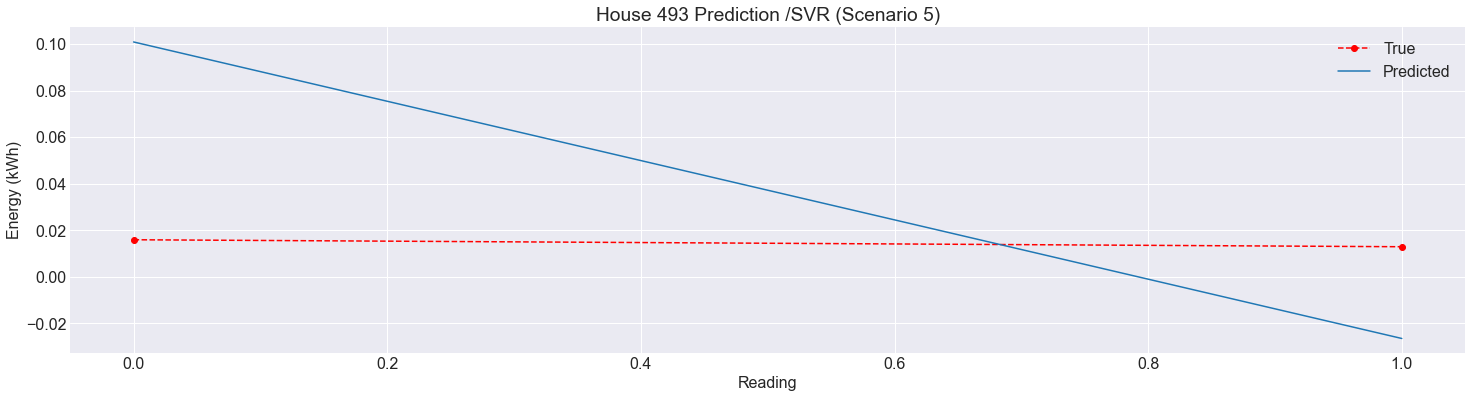

Mse:  0.033771143784506
Rmse: 0.183769267791179
Mae:  0.174877713928568
Mape:  39.756610002980061


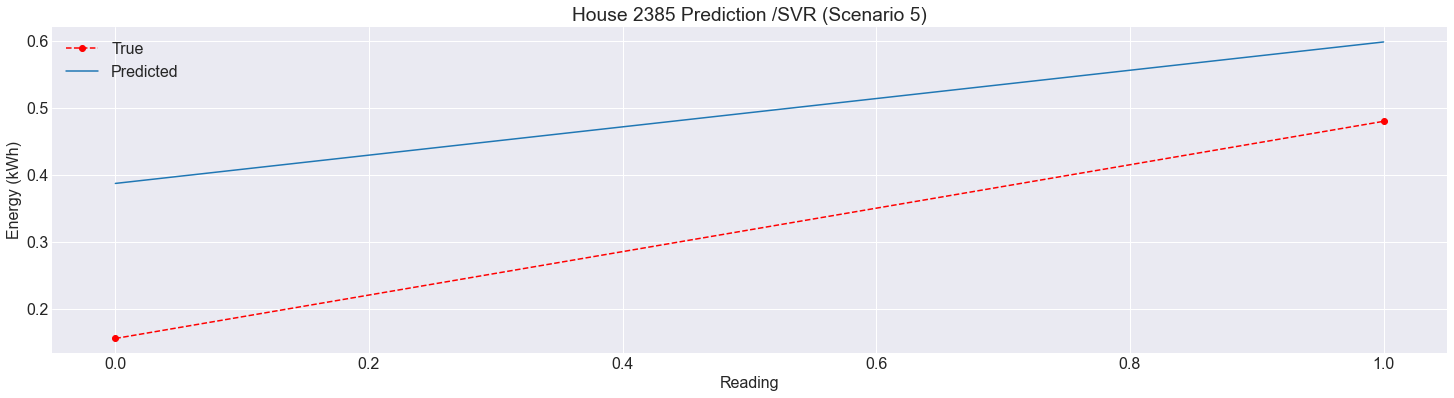

Mse:  0.005599111060496
Rmse: 0.074827208022860
Mae:  0.074584121392360
Mape:  48.172956627812731


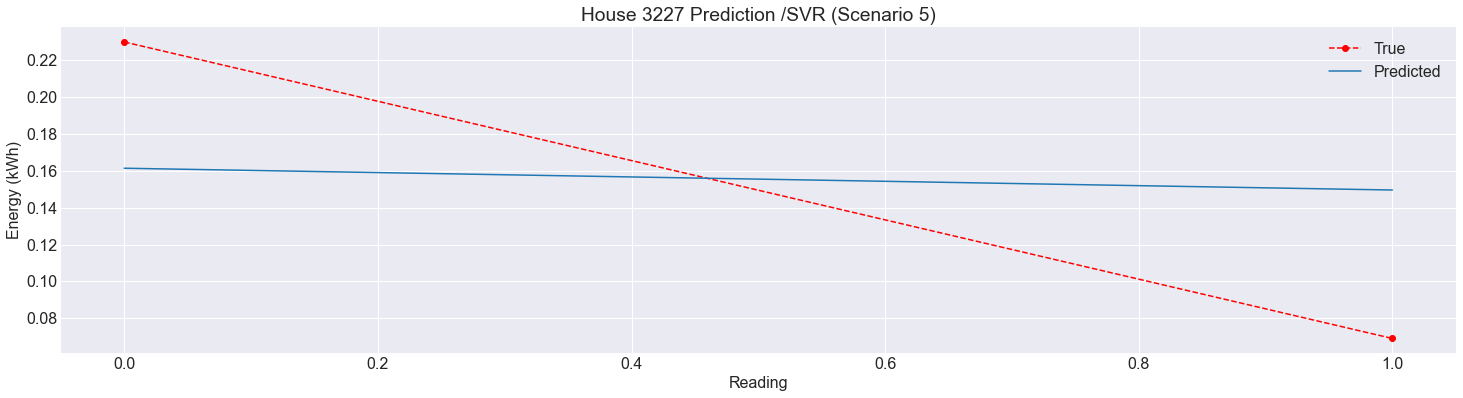

Mse:  0.049933446335854
Rmse: 0.223457929677722
Mae:  0.163017746503173
Mape:  85.711849725176577


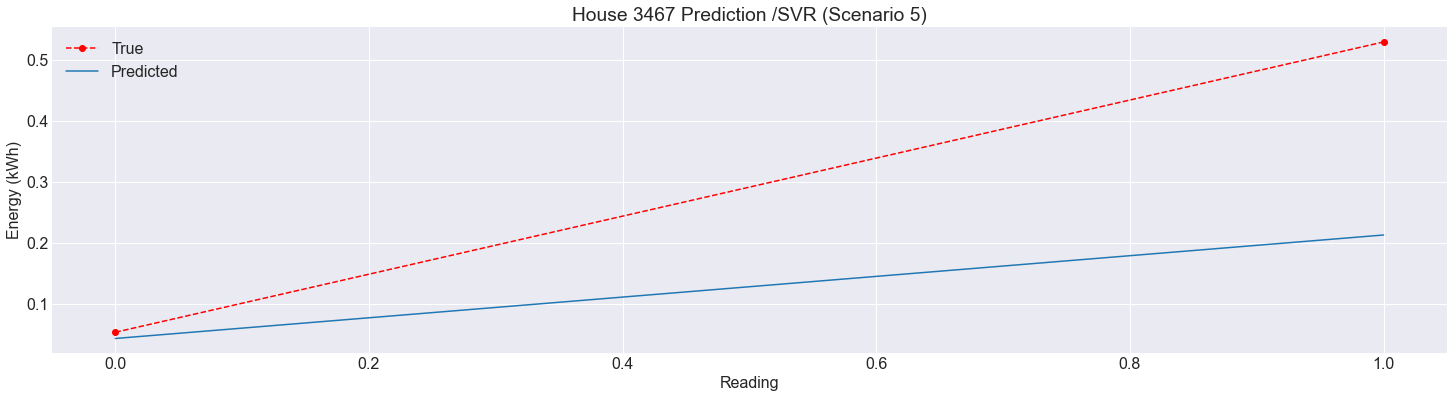

Mse:  0.027361172958180
Rmse: 0.165412130625839
Mae:  0.149556720581091
Mape:  54.223884936414521


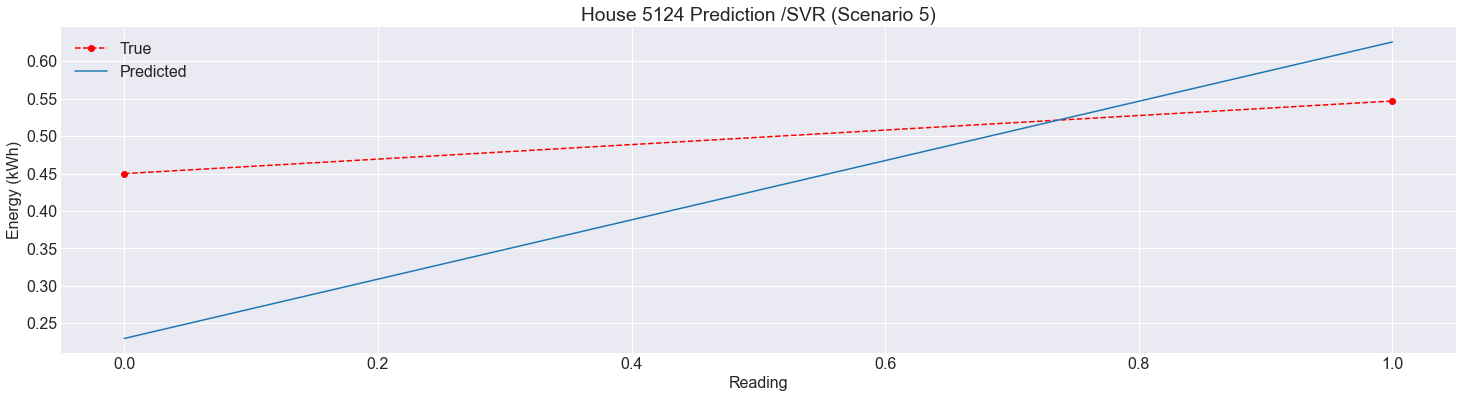

Mse:  0.000042145372235
Rmse: 0.006491946721522
Mae:  0.005795161660390
Mape:  1.944821326266761


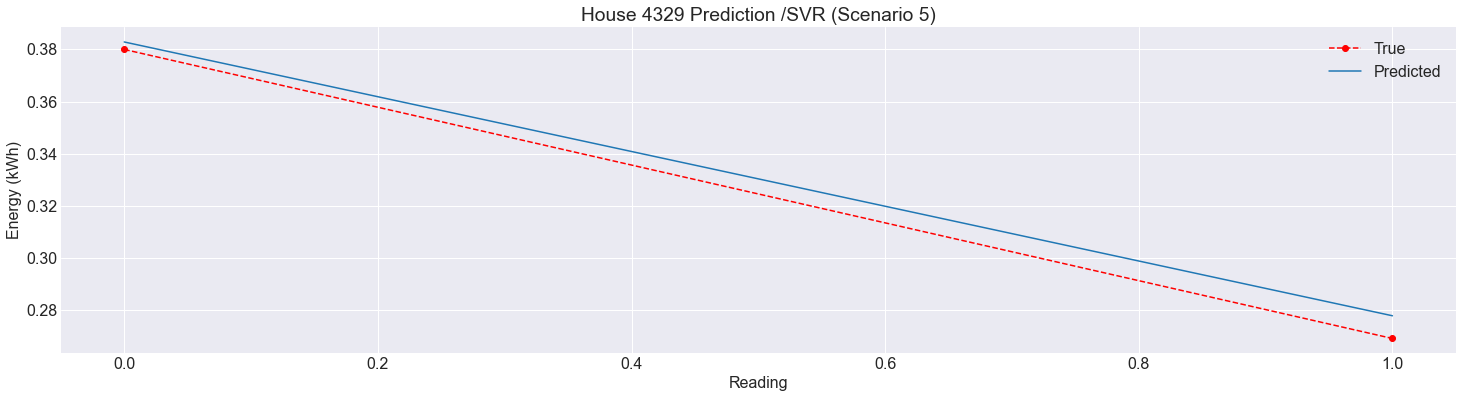

In [134]:
 ##### The households with an error have a '#' 
predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)




In [ ]:
models_performances_HH_level_Regression = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level_Regression

,HH_1,HH_2,HH_3,HH_4,HH_5,HH_6,HH_7,HH_8,HH_9,HH_10,...,HH_20,HH_21,HH_22,HH_23,HH_24,HH_25,HH_26,HH_27,HH_28,HH_29
MSE_scores,0.001185,0.016665,0.095310,0.008331,0.000139,0.034405,0.021092,0.001656,0.016714,0.009877,...,0.004369,0.035922,0.006263,0.002404,0.004393,0.033771,0.005599,0.049933,0.027361,0.000042
RMSE_scores,0.034422,0.129093,0.308723,0.091274,0.011803,0.185485,0.145232,0.040689,0.129283,0.099383,...,0.066095,0.189530,0.079140,0.049027,0.066281,0.183769,0.074827,0.223458,0.165412,0.006492
MAE_scores,0.032033,0.122331,0.295603,0.072468,0.011803,0.166051,0.141128,0.040061,0.110907,0.076169,...,0.066087,0.189235,0.073112,0.047706,0.062237,0.174878,0.074584,0.163018,0.149557,0.005795
MAPE_scores,33.245430,179.639573,46.773870,73.046053,27.472656,313.652963,176.324801,38.745609,74.889263,32.705782,...,22.509657,77.215068,65.896377,30.169725,116.665693,39.756610,48.172957,85.711850,54.223885,1.944821


In [ ]:
models_performances_HH_level_Regression.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario1_1h_SVR.csv', index=False)